# Exploratory Analysis

## Introduction

**Context & Motivation**

Vaccination is a cornerstone of public health, contributing significantly to the prevention of disease and the reduction of child mortality worldwide. Despite its proven effectiveness, global access to and trust in vaccines remains uneven — influenced by political, economic, and cultural factors. This project explores these dynamics from a data-driven perspective.

**Objectives**

The goal of this exploratory data analysis is to understand global trends in child routine vaccination and investigate potential factors associated with vaccination uptake across countries and over time. Specifically, the project aims to:

1. Analyze vaccination rates across world regions and track their progression over time.
2. Examine the relationship between vaccination rates and socio-economic variables such as GDP, health expenditure, internet usage, and child mortality.
3. Explore the role of institutional trust and polarization — as a potential correlate or moderator of vaccine uptake.

**Data Sources**

This analysis is based on a combined dataset constructed from publicly available sources:
- UNICEF (child vaccination data)
- World Bank (GDP, health expenditure, internet usage, child mortality)
- V-Dem (political polarization)
- Trust in government (OECD)

All data were cleaned, merged, and aligned using consistent country and year identifiers to allow for meaningful cross-country comparisons. The final dataset  includes the following variables:
1. **country** - name of countries
2. **region** - region name - USND
3. **subregion** - sub-region name - USND
4. **year** - applicable year
5. **vac_index** - index of vaccination calculated as average of % ofvaccinated population with globally recommended vaccines (BCG, DTP3, POL3, IPV2, MCV2, RCV1, HEPB3, HEPBB, HIB3, PCV3, ROTAC) - UNICEF
6. **gpd** - gdp per capita (US$) - World Bank
7. **health_exp** - health expenditure (% of GDP) - World Bank
8. **child_mort** - under 5 years old children mortality (per 1000 live births) - World Bank
9. **internet_use** - % of population using internet - World Bank
10. **gov_trust** - % of population trusting government (yes/no) - UNICEF
11. **polarization** - score based on expert assessments of societal divisions - V-Dem

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr

In [2]:
#ignoring future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#setting report plots style and theme
sns.set_theme(rc={'figure.figsize':(12,6)})
sns.set_style("white")

## Basic Statistics

In [4]:
#reading the file
df = pd.read_csv('00_Immunization_db.csv')

#loading first records
df.head()

country  region           subregion iso3  year  vac_index       gdp  \
0  Afghanistan    Asia       Southern Asia  AFG  2012      62.50    651.42   
1      Albania  Europe     Southern Europe  ALB  2012      98.33   4247.63   
2      Algeria  Africa     Northern Africa  DZA  2012      96.14   6033.65   
3      Andorra  Europe     Southern Europe  AND  2012      96.29  41500.54   
4       Angola  Africa  Sub-Saharan Africa  AGO  2012      56.80   5086.03   

   health_exp  child_mort  internet_use  gov_trust  polarization  
0        7.90        81.2          5.45        NaN          1.02  
1        6.16        11.2         49.40        NaN          1.40  
2        5.64        26.6         18.20        NaN          0.66  
3        6.71         4.1         82.70        NaN           NaN  
4        2.40       104.8          7.70        NaN         -1.14

### Trends Over Time Dataset

In [5]:
#checking data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1991 non-null   object 
 1   region        1991 non-null   object 
 2   subregion     1991 non-null   object 
 3   iso3          1991 non-null   object 
 4   year          1991 non-null   int64  
 5   vac_index     1991 non-null   float64
 6   gdp           1991 non-null   float64
 7   health_exp    1991 non-null   float64
 8   child_mort    1991 non-null   float64
 9   internet_use  1991 non-null   float64
 10  gov_trust     411 non-null    float64
 11  polarization  1804 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 186.8+ KB


There are several missing countries for polarization variable, however it will be mostly used as moderator that main predictor. For government trust only OECD countries are included.

In [6]:
df.describe()

year    vac_index            gdp   health_exp   child_mort  \
count  1991.000000  1991.000000    1991.000000  1991.000000  1991.000000   
mean   2017.000000    85.497092   15364.740578     6.593626    29.082622   
std       3.163072    12.750998   23946.501051     2.939276    31.290466   
min    2012.000000    25.330000     210.010000     1.510000     2.200000   
25%    2014.000000    79.880000    2052.140000     4.390000     6.700000   
50%    2017.000000    89.560000    5905.080000     6.210000    17.100000   
75%    2020.000000    94.880000   18174.895000     8.415000    43.350000   
max    2022.000000    99.000000  226052.000000    24.080000   387.400000   

       internet_use   gov_trust  polarization  
count   1991.000000  411.000000   1804.000000  
mean      53.621959   45.400146      0.842106  
std       29.089741   15.236342      1.112239  
min        1.040000   15.710000     -2.660000  
25%       26.550000   32.670000      0.277500  
50%       57.300000   43.810000      1.040000  
75%       79.000000   56.470000      1.580000  
max      100.000000   84.680000      3.330000

Standard deviation for gdp per capita is very large. Morever the difference between 75th percentile and maximum value is very big - possible impact caused by outliers.

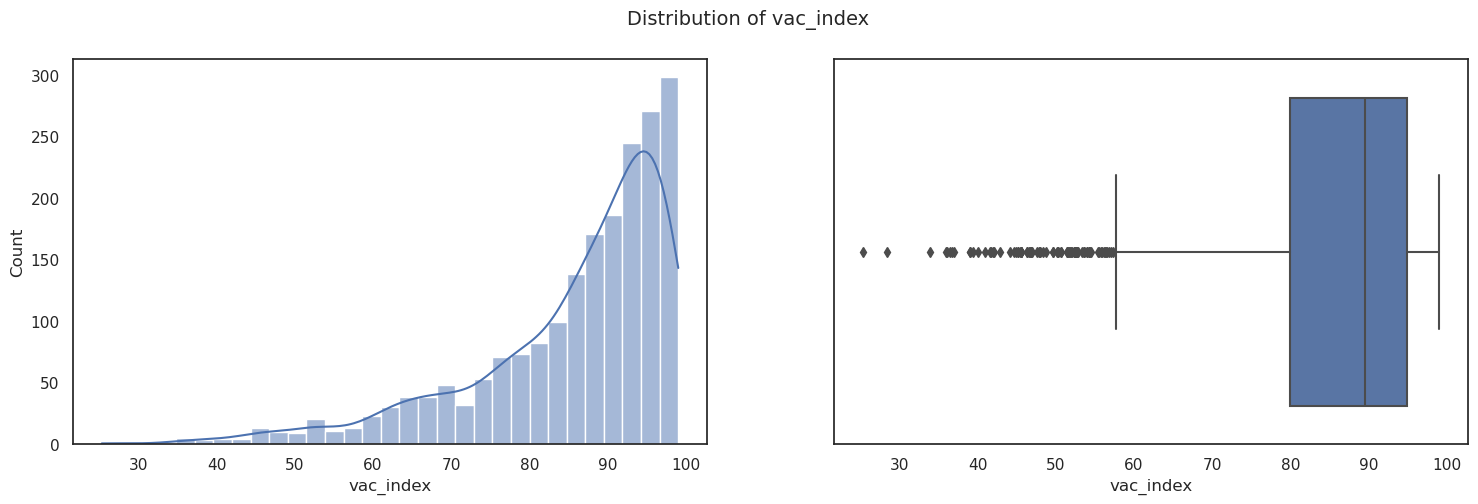

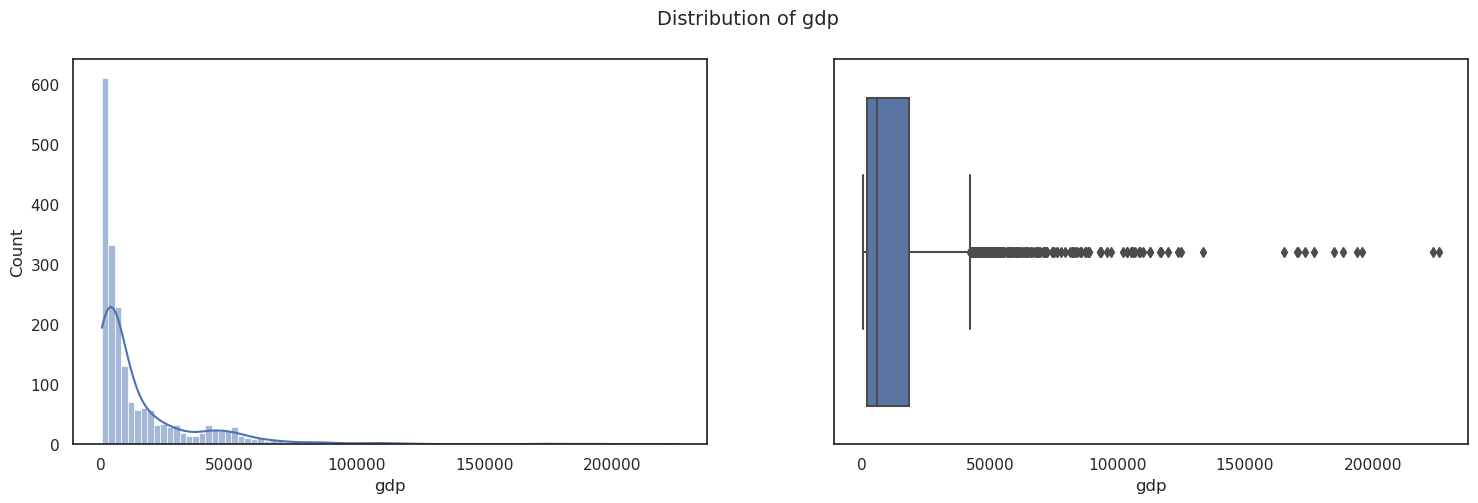

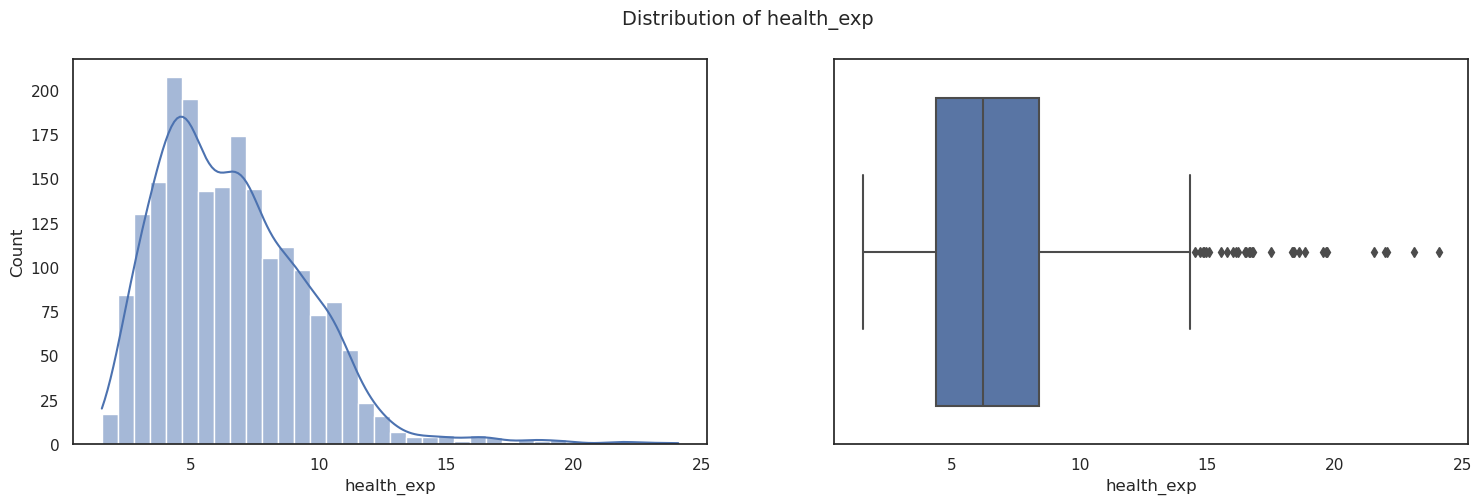

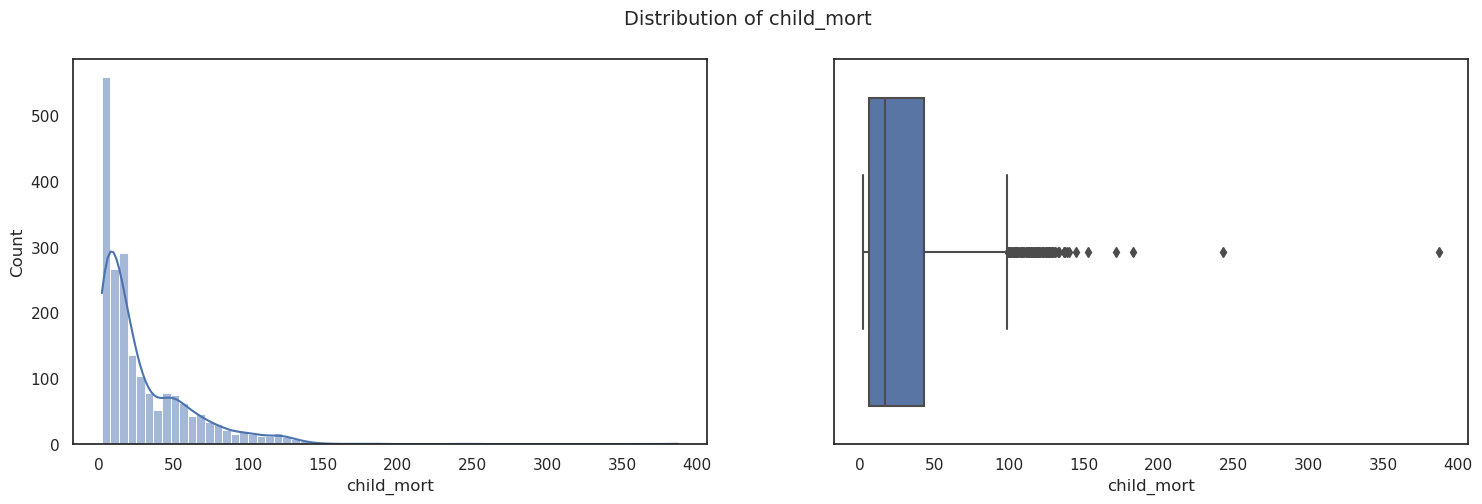

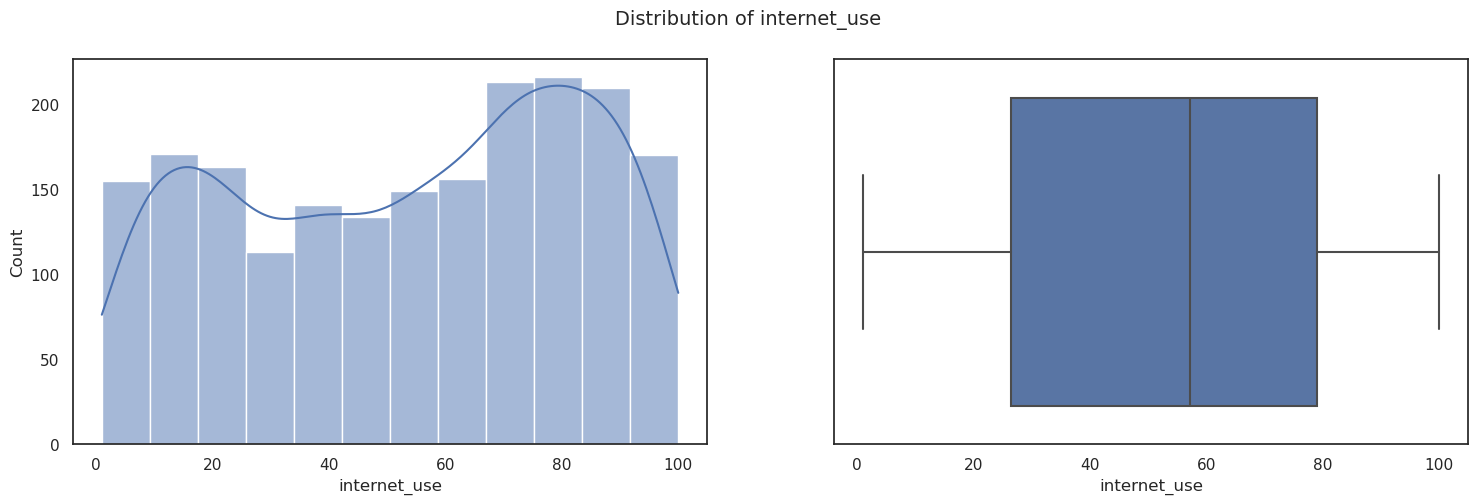

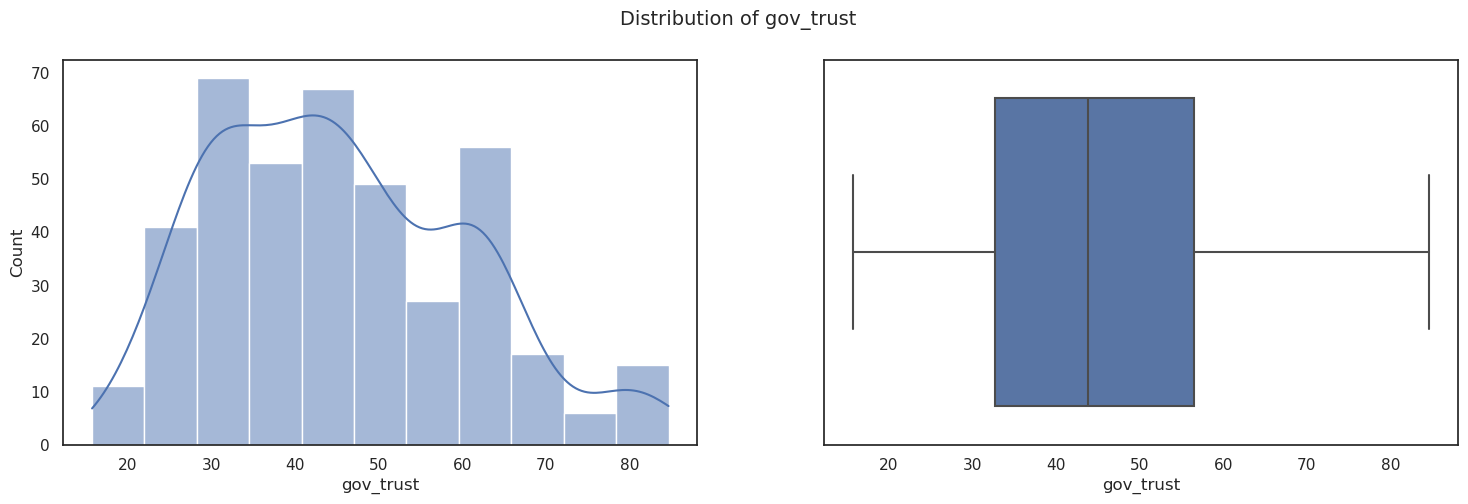

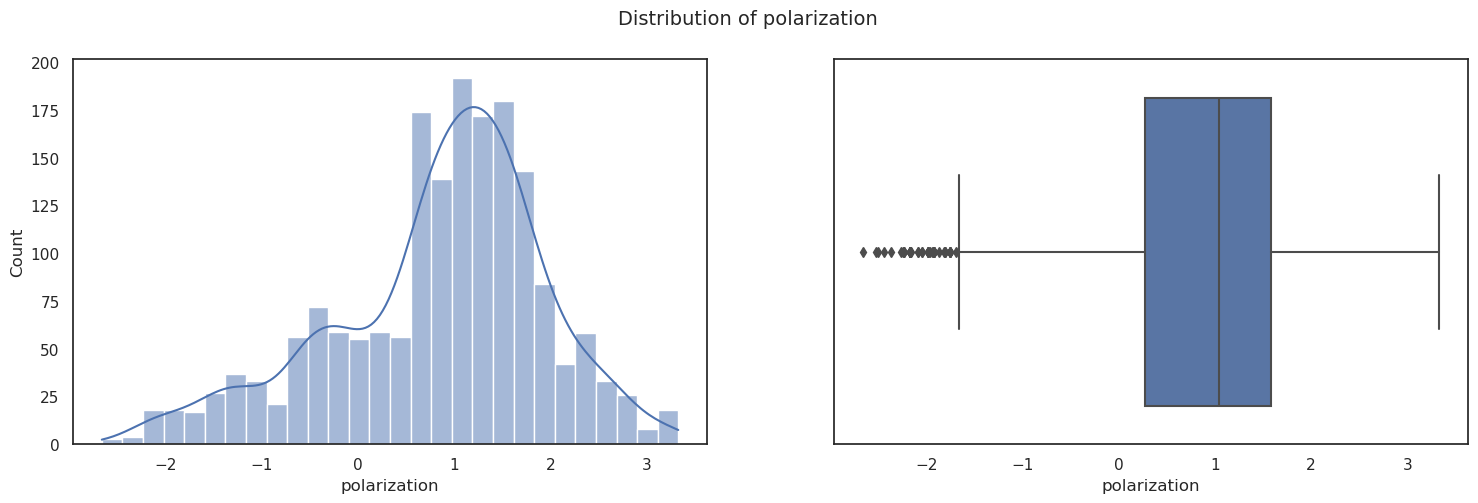

In [136]:
#visualizing distributions - histograms and boxplots for numeric columns
cols = ['vac_index', 'gdp', 'health_exp', 'child_mort', 'internet_use', 'gov_trust', 'polarization']

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])
    fig.suptitle(f'Distribution of {col}', fontsize=14)

### Average Values Dataset

In [8]:
avg_df = df.groupby(["country", "region", "subregion", "iso3"]).mean().round(2).reset_index()
avg_df.drop("year", axis=1, inplace=True)
avg_df.head()

country  region           subregion iso3  vac_index       gdp  \
0  Afghanistan    Asia       Southern Asia  AFG      57.60    521.74   
1      Albania  Europe     Southern Europe  ALB      97.66   5027.60   
2      Algeria  Africa     Northern Africa  DZA      90.53   4880.36   
3      Andorra  Europe     Southern Europe  AND      96.40  41279.70   
4       Angola  Africa  Sub-Saharan Africa  AGO      49.21   3058.44   

   health_exp  child_mort  internet_use  gov_trust  polarization  
0       13.63       68.27         12.38        NaN          0.18  
1        6.66        9.72         63.86        NaN          1.48  
2        5.56       24.20         46.75        NaN          0.70  
3        7.32        3.30         89.62        NaN           NaN  
4        2.73       82.49         26.59        NaN         -0.46

In [9]:
avg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       181 non-null    object 
 1   region        181 non-null    object 
 2   subregion     181 non-null    object 
 3   iso3          181 non-null    object 
 4   vac_index     181 non-null    float64
 5   gdp           181 non-null    float64
 6   health_exp    181 non-null    float64
 7   child_mort    181 non-null    float64
 8   internet_use  181 non-null    float64
 9   gov_trust     38 non-null     float64
 10  polarization  164 non-null    float64
dtypes: float64(7), object(4)
memory usage: 15.7+ KB


In [10]:
avg_df.describe()

vac_index            gdp  health_exp  child_mort  internet_use  \
count  181.000000     181.000000  181.000000  181.000000    181.000000   
mean    85.497403   15364.740718    6.593702   29.082762     53.621547   
std     11.810323   23747.232252    2.787003   30.545837     26.726336   
min     43.610000     234.540000    2.180000    2.450000      4.700000   
25%     79.930000    2031.490000    4.400000    7.110000     30.130000   
50%     89.420000    6014.960000    6.140000   17.270000     57.330000   
75%     94.170000   18295.350000    8.330000   46.150000     77.290000   
max     98.850000  188145.130000   17.740000  170.480000     98.460000   

       gov_trust  polarization  
count  38.000000    164.000000  
mean   45.684737      0.841951  
std    14.127444      1.081362  
min    27.370000     -2.170000  
25%    36.007500      0.260000  
50%    41.440000      1.050000  
75%    57.500000      1.565000  
max    82.570000      3.240000

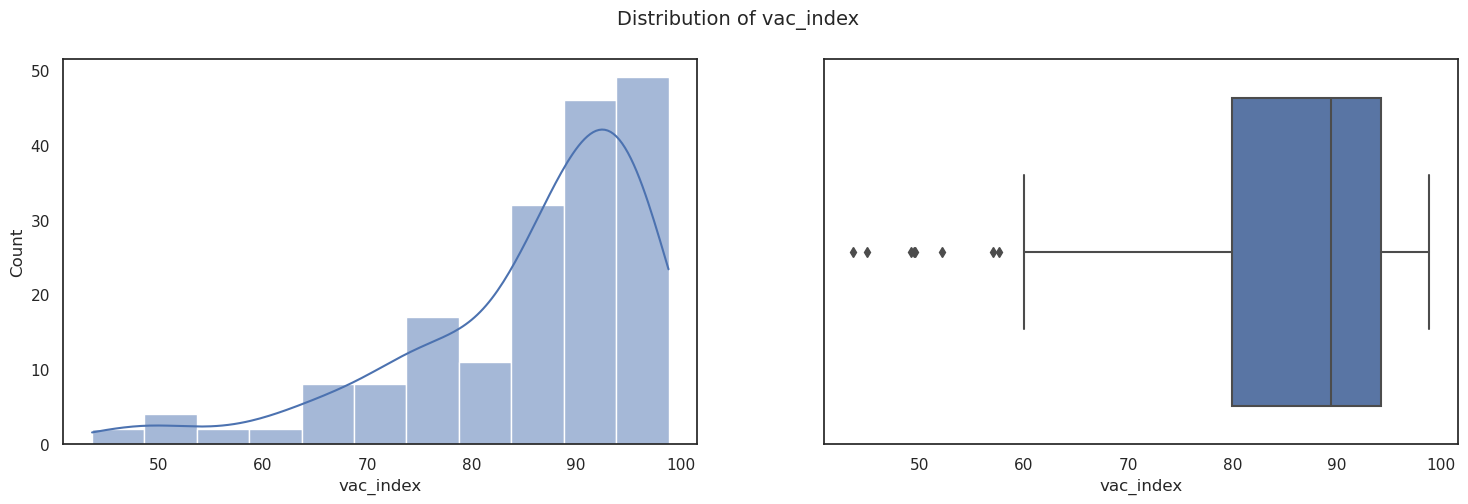

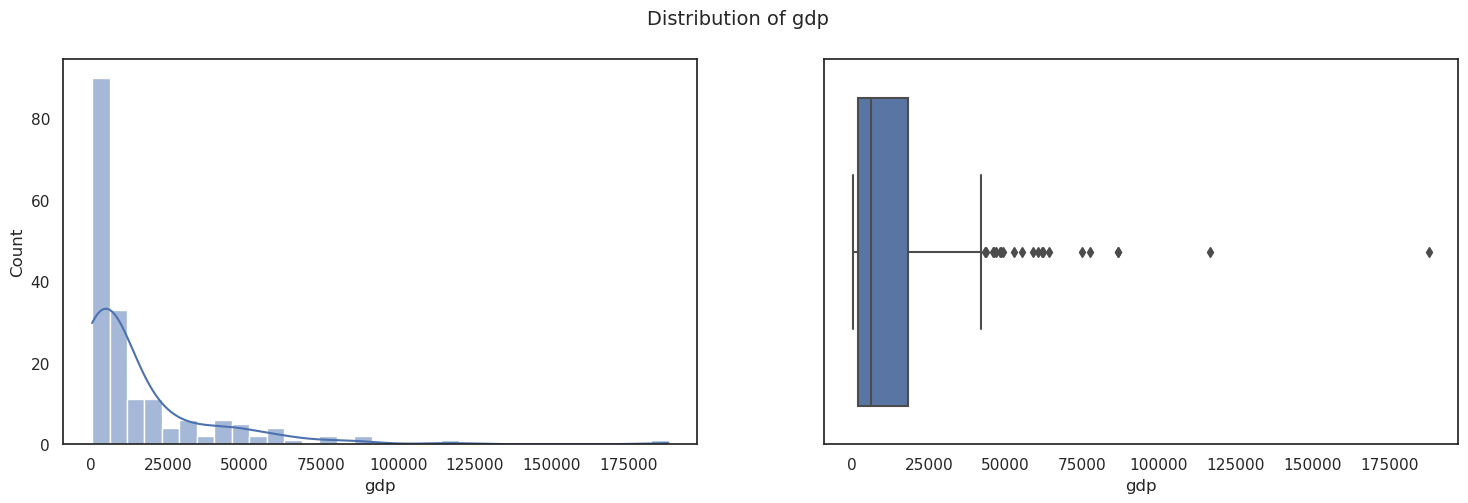

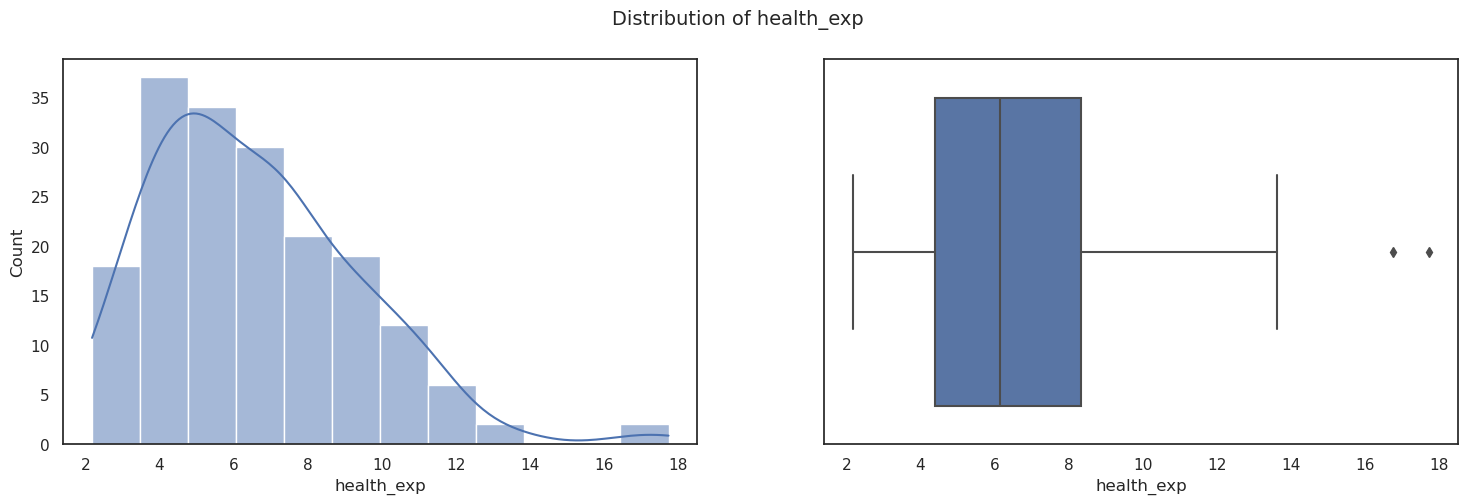

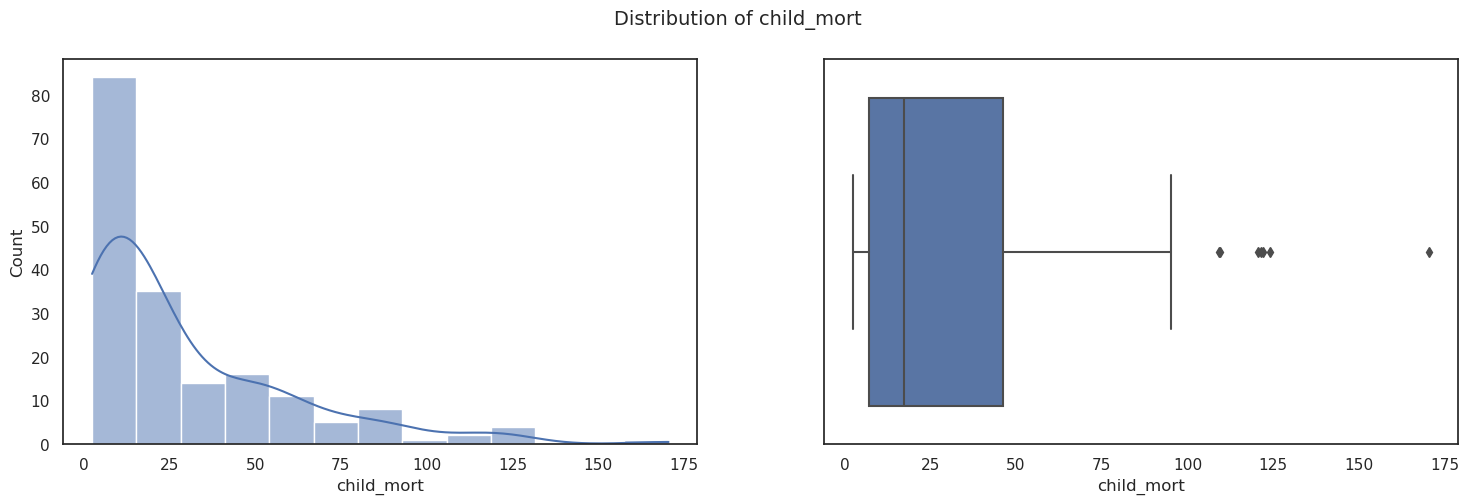

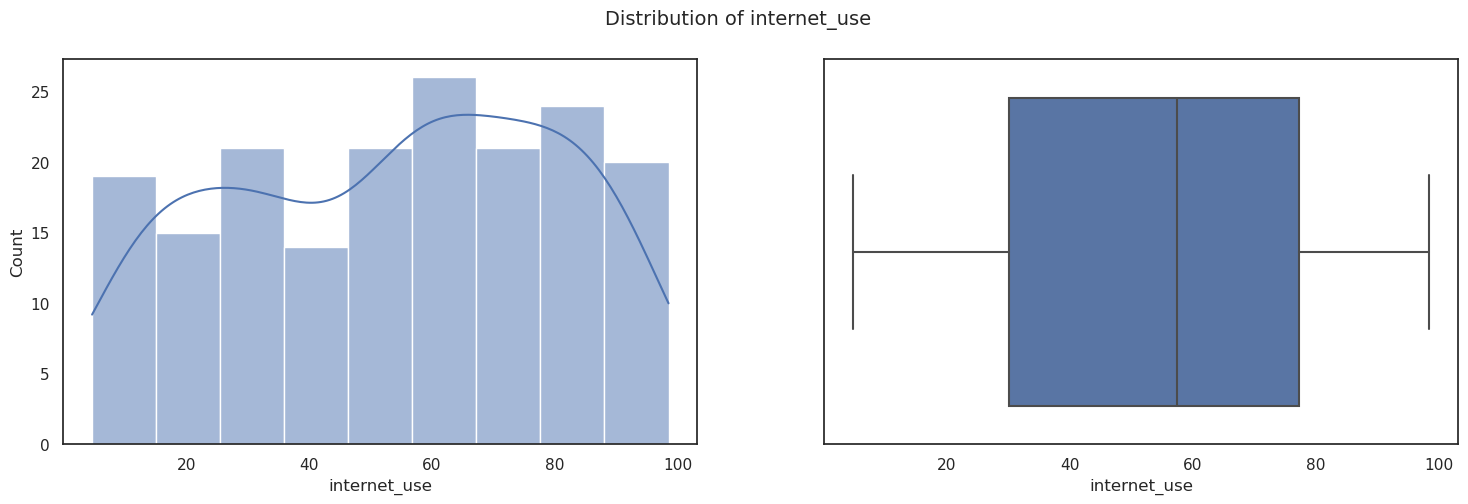

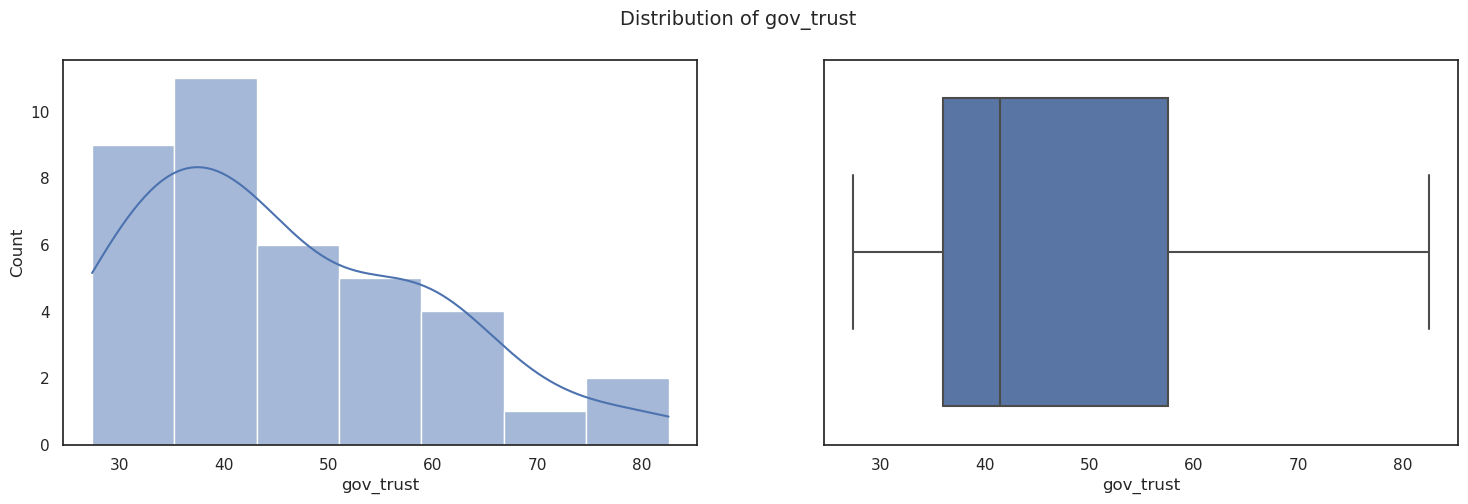

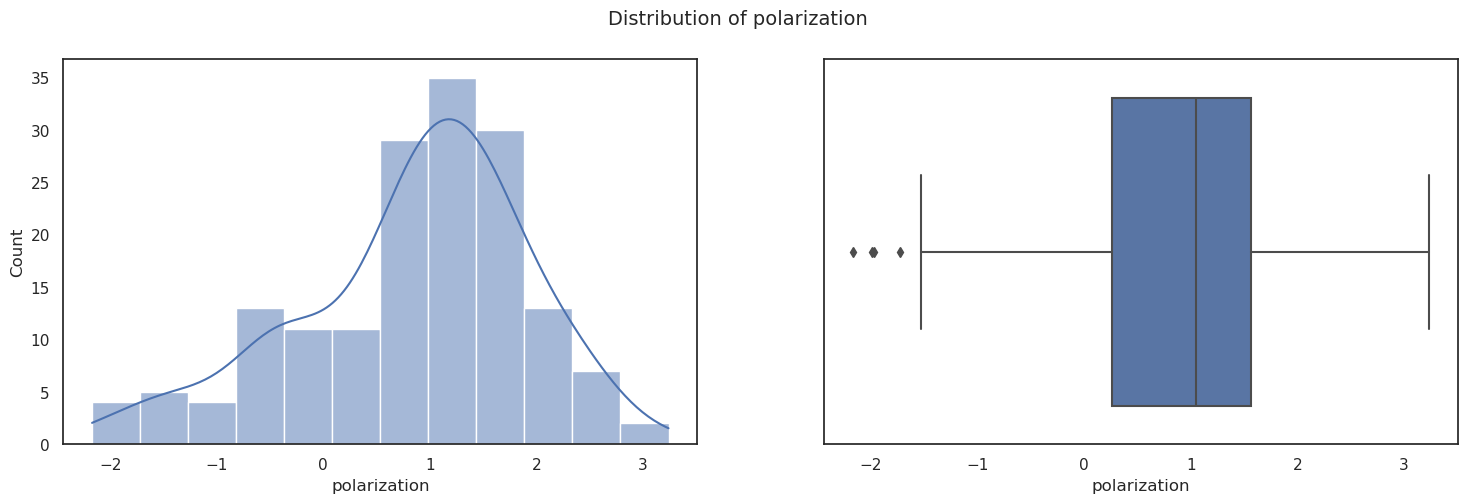

In [11]:
#visualizing distributions - histograms and boxplots for numeric columns
for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    sns.histplot(avg_df[col], kde=True, ax=axes[0])
    sns.boxplot(x=avg_df[col], ax=axes[1])
    fig.suptitle(f'Distribution of {col}', fontsize=14)

### Outliers

Let's detect outliers for the future analysis:

In [12]:
#creating function detecting outliers (IQR method)
def detect_outliers_iqr(df, column):
    """
    Detects outliers in a specified column of a dataframe using the Interquartile Range (IQR) method.
    
    The function calculates the first (Q1) and third (Q3) quartiles, the IQR (Q3 - Q1), 
    and defines the outlier bounds as 1.5 * IQR below Q1 and 1.5 * IQR above Q3.
    Any value outside these bounds is considered an outlier and is marked as True in the 
    new column created for outliers.
    
    Args:
    df (pandas.DataFrame): The dataframe containing the data.
    column (str): The name of the column in the dataframe to check for outliers.
    
    Returns:
    pandas.DataFrame: The original dataframe with an additional column indicating 
                       whether each value is an outlier.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a new column with True/False if it's an outlier
    outlier_col = f"{column}_outlier"
    df[outlier_col] = (df[column] < lower_bound) | (df[column] > upper_bound)

    return df

In [13]:
# Applying to the average values dataframe
for col in ['gdp', 'health_exp', 'child_mort', 'vac_index']:
    avg_df = detect_outliers_iqr(avg_df, col)

avg_df["any_outlier"] = avg_df[["gdp_outlier", "health_exp_outlier", "child_mort_outlier", "vac_index_outlier"]].any(axis=1)

In [14]:
avg_df.shape

(181, 16)

Checking outliers:

In [15]:
# Columns to check
outlier_cols = ["gdp_outlier", "health_exp_outlier", "child_mort_outlier", "vac_index_outlier"]

# Dictionary to store results
outlier_countries = {}

# Loop through each column and get unique countries with True
for col in outlier_cols:
    countries = avg_df[avg_df[col] == True]['country'].unique()
    outlier_countries[col] = sorted(countries)

# Print the results
for col, countries in outlier_countries.items():
    print(f"\nOutliers in '{col}' ({len(countries)} countries):")
    print(countries)


Outliers in 'gdp_outlier' (21 countries):
['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'Germany', 'Iceland', 'Ireland', 'Luxembourg', 'Monaco', 'Netherlands', 'New Zealand', 'Norway', 'Qatar', 'Singapore', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']

Outliers in 'health_exp_outlier' (2 countries):
['Tuvalu', 'United States']

Outliers in 'child_mort_outlier' (7 countries):
['Central African Republic', 'Chad', 'Guinea', 'Mali', 'Niger', 'Nigeria', 'Sierra Leone']

Outliers in 'vac_index_outlier' (8 countries):
['Afghanistan', 'Angola', 'Central African Republic', 'Chad', 'Guinea', 'Nigeria', 'Papua New Guinea', 'Yemen']


I wouldn't like to remove any outlier countries. However, we might create separate analysis to check values for dataset without outliers, thus let's create them:

In [16]:
#cleaning averages
df_avg_clean = avg_df[~avg_df['any_outlier']]
df_avg_cleangdp = avg_df[~avg_df['gdp_outlier']]


# Applying function detecting outliers to the time trends dataframe
for col in ['gdp', 'health_exp', 'child_mort', 'vac_index']:
    df = detect_outliers_iqr(df, col)

time_df = df
time_df_cleangdp = df[~df['gdp_outlier']]

### Correlations

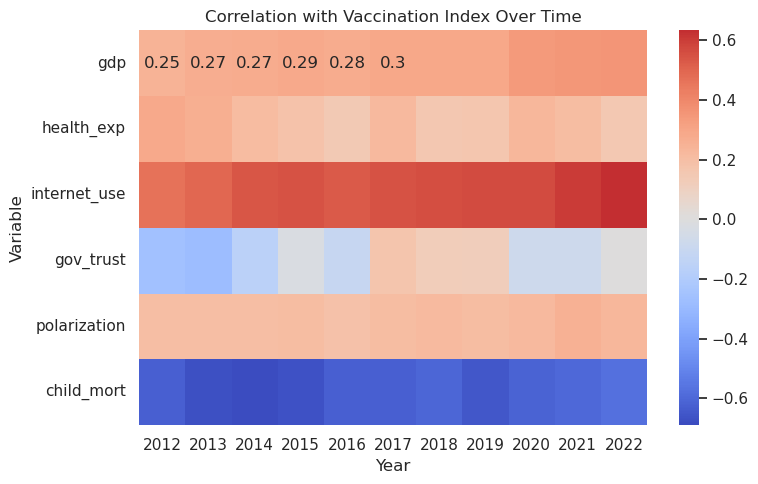

In [137]:
#Iterating through years to create correlation matrix for all years 
corrs = []

for year in df['year'].unique():
    subset = df[df['year'] == year] #Filter the dataframe to keep only rows for that particular year
    corr = subset[['vac_index', 'gdp', 'health_exp', 'internet_use', 'gov_trust', 'polarization', 'child_mort']].corr() 
    #Calculate the correlation matrix for selected columns within the year
    corrs.append(corr['vac_index'].drop('vac_index')) #appending to the corrs list 

corr_df = pd.DataFrame(corrs, index=sorted(df['year'].unique())) #dreating cerrelations df

#plotting correlations matrix
plt.figure(figsize=(8, 5))
sns.heatmap(corr_df.T, cmap='coolwarm', annot=True, center=0)
plt.title('Correlation with Vaccination Index Over Time')
plt.xlabel('Year')
plt.ylabel('Variable')
plt.tight_layout()
plt.savefig('01_correlations_matrix.png', bbox_inches='tight')
plt.show()

Interesting. The following correlations change with time:
1. **GDP per capita** - correlation slightly grow with time
2. **Internet use** - the relationship clearly gets stronger with time, being around 0.4 in 2012, and around 0.6 in 2021
3. **Trust in government** - this variable includes data for OECD countries only. The relationship between trust in government. and vaccination score shifted its direction through time. In 2012 it was negative, around -0.2 and it has been weakening with time, being positive (0-0.2) in years 2017-2019, shifting to negative relation in 2020 again. Fascinating.

Those trends still can be insignificant or a result of different number of records per year - it will be investigated later in the analysis.

In [18]:
#checking correlations for average values
avg_df.select_dtypes(include='number').corr()

vac_index       gdp  health_exp  child_mort  internet_use  \
vac_index      1.000000  0.324733    0.225498   -0.693956      0.609593   
gdp            0.324733  1.000000    0.239326   -0.434648      0.665505   
health_exp     0.225498  0.239326    1.000000   -0.274208      0.306030   
child_mort    -0.693956 -0.434648   -0.274208    1.000000     -0.801878   
internet_use   0.609593  0.665505    0.306030   -0.801878      1.000000   
gov_trust     -0.030606  0.763820    0.145149   -0.204571      0.562147   
polarization   0.233577  0.328746    0.436780   -0.244818      0.306916   

              gov_trust  polarization  
vac_index     -0.030606      0.233577  
gdp            0.763820      0.328746  
health_exp     0.145149      0.436780  
child_mort    -0.204571     -0.244818  
internet_use   0.562147      0.306916  
gov_trust      1.000000      0.220962  
polarization   0.220962      1.000000

Correlations might change for data without outliers:

In [19]:
df_avg_clean.select_dtypes(include='number').corr()

vac_index       gdp  health_exp  child_mort  internet_use  \
vac_index      1.000000  0.432845    0.202917   -0.592074      0.563351   
gdp            0.432845  1.000000    0.243403   -0.569754      0.762866   
health_exp     0.202917  0.243403    1.000000   -0.293965      0.255254   
child_mort    -0.592074 -0.569754   -0.293965    1.000000     -0.820434   
internet_use   0.563351  0.762866    0.255254   -0.820434      1.000000   
gov_trust      0.326579  0.003315   -0.378686    0.206797     -0.063506   
polarization   0.196631  0.263017    0.381365   -0.226891      0.222667   

              gov_trust  polarization  
vac_index      0.326579      0.196631  
gdp            0.003315      0.263017  
health_exp    -0.378686      0.381365  
child_mort     0.206797     -0.226891  
internet_use  -0.063506      0.222667  
gov_trust      1.000000     -0.268956  
polarization  -0.268956      1.000000

Without outliers correlations change. Correlation with health expenditure, children mortality and internet use is lower, and with gdp, government trust and polarization is higher. Intrestingly, government trust correlated highly with gdp (0.76) with outliers and there is no correlation without them. At the same time there was no correlation with government trust with outliers and there is 0.33 correlations without them. Gdp outliers influenced government trust a lot. 

In [20]:
df_avg_cleangdp.select_dtypes(include='number').corr()

vac_index       gdp  health_exp  child_mort  internet_use  \
vac_index      1.000000  0.435913    0.227039   -0.685277      0.612599   
gdp            0.435913  1.000000    0.198310   -0.535153      0.768041   
health_exp     0.227039  0.198310    1.000000   -0.217345      0.203521   
child_mort    -0.685277 -0.535153   -0.217345    1.000000     -0.792819   
internet_use   0.612599  0.768041    0.203521   -0.792819      1.000000   
gov_trust      0.326579  0.003315   -0.378686    0.206797     -0.063506   
polarization   0.222024  0.265697    0.346143   -0.193177      0.230798   

              gov_trust  polarization  
vac_index      0.326579      0.222024  
gdp            0.003315      0.265697  
health_exp    -0.378686      0.346143  
child_mort     0.206797     -0.193177  
internet_use  -0.063506      0.230798  
gov_trust      1.000000     -0.268956  
polarization  -0.268956      1.000000

Removing only gdp outliers balances the correlations. Almost all variables correlate similarly, except gdp that is 0.1 higher and government_trust that is more that 0.3 higher.

## Vaccination Index

#### Trends over time

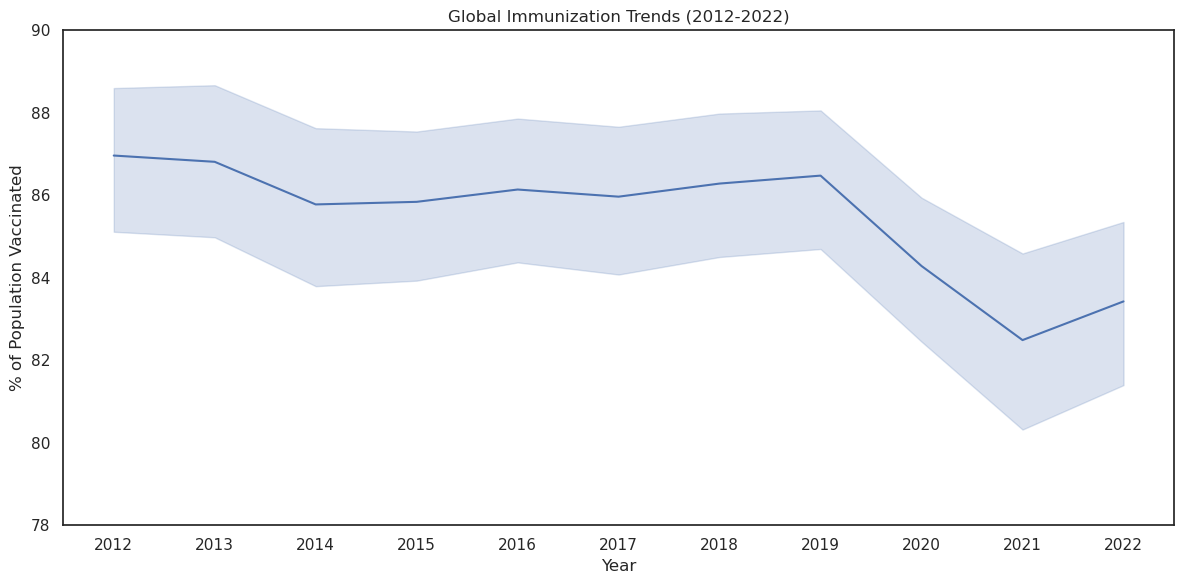

In [138]:
#creating line plot
sns.lineplot(data=time_df, x='year', y='vac_index', estimator='mean')

#setting up title and axis names
plt.title('Global Immunization Trends (2012-2022)')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("Year")

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))
plt.ylim(78, 90)

plt.tight_layout()
plt.savefig('02_global_immunization_trends.png', bbox_inches='tight')
plt.show()

Globally, % of population vaccinated slightly decreased in 2012-2014, and remained stable till 2019. As expected, there was a significant drop (around 5%) in immunization in 2019 till 2021. In 2022 immunization score rised. This is likely lined with the COVID-19 epidemic. Let's explore futher.

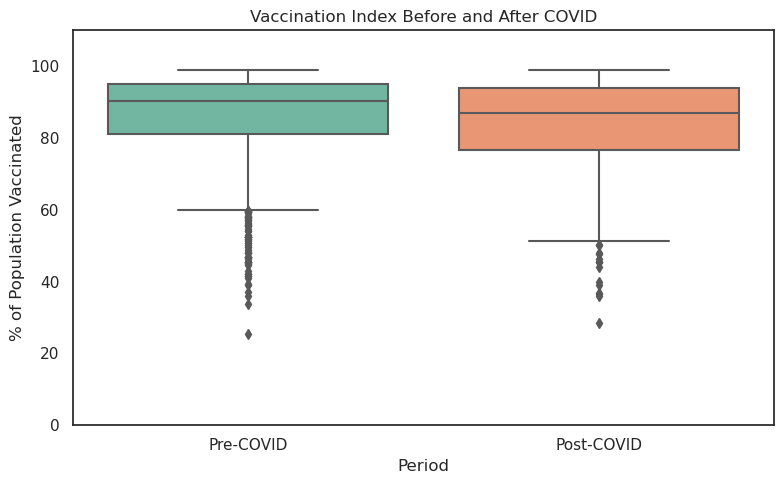

In [139]:
time_df['period'] = time_df['year'].apply(lambda x: 'Pre-COVID' if x < 2020 else 'Post-COVID')

plt.figure(figsize=(8, 5))
sns.boxplot(data=time_df, x='period', y='vac_index', palette="Set2")

plt.title('Vaccination Index Before and After COVID')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("Period")
plt.ylim(0, 110)

plt.tight_layout()
plt.savefig('03_pre_post_covid_comparison.png', bbox_inches='tight')
plt.show()

The 25th percent didn't change after post-covid, thus there are still many countries keeping hign vaccinations score. Median and 75th percentile dropped though. Interestingly in the pre-covid era, there were much our bottom outliers than post-covid. 

## Regions

#### Average Vaccination Score

In [23]:
#creating a map for average vaccination score
fig = px.choropleth(df, locations="iso3", color="vac_index", hover_name="country",
    hover_data={"iso3": False, "vac_index": ':.1f'},  # Hide iso3, format vac_index
    color_continuous_scale="Blues", range_color=(0, 100), )

# Update layout
fig.update_layout(title="World Vaccination Index (% of Population Vaccinated)", width=850,  height=600,  
    coloraxis_colorbar=dict(
        title="% of population vaccinated",
        tickvals=[0, 20, 40, 60, 80, 100],  # Tick intervals
        ticks="outside",
        titlefont=dict(size=12),  # Size of the legend title
        tickfont=dict(size=10)    # Size of the tick labels
    ),
                  
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth',
        lonaxis=dict(range=[-180, 180]), #changing default view for the whole world
        lataxis=dict(range=[-60, 90]),
    ),
)

# Hover style
fig.update_traces(
    hoverlabel=dict(
        bgcolor="white",
        font_size=13,
        font_color="black"
    )
)

fig.show()

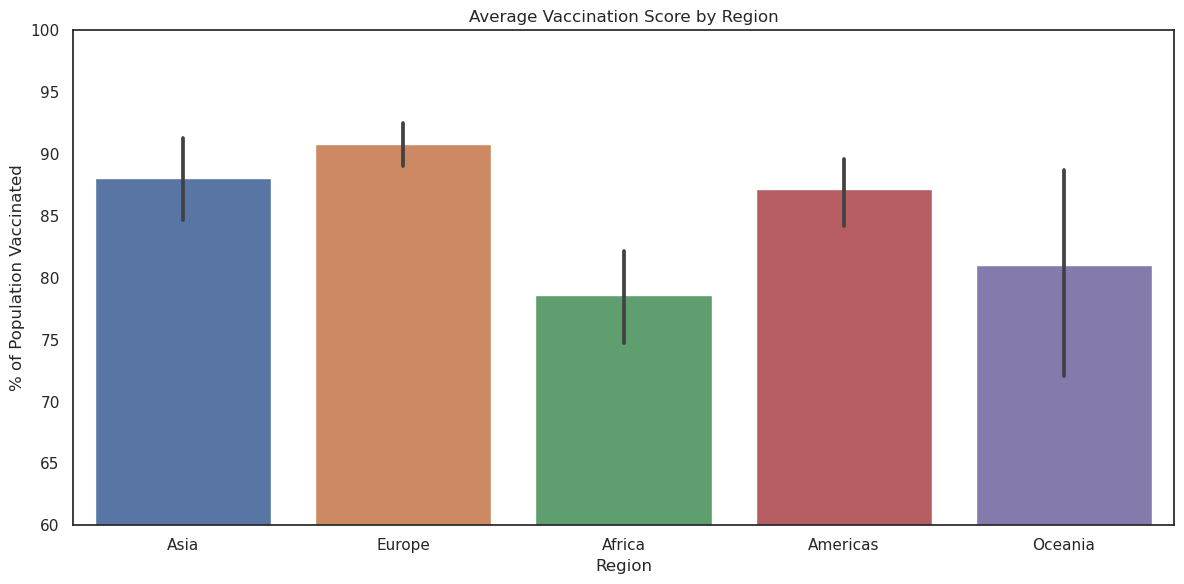

In [24]:
sns.barplot(data=avg_df, x="region", y="vac_index", estimator='mean')

plt.title('Average Vaccination Score by Region')
plt.ylabel('% of Population Vaccinated')
plt.xlabel('Region')
plt.ylim(60, 100)

plt.tight_layout()
plt.show()

In [25]:
avg_df.sort_values(by='vac_index', ascending=False).head(10)

country    region                        subregion iso3  \
124               Oman      Asia                     Western Asia  OMN   
43                Cuba  Americas  Latin America and the Caribbean  CUB   
73             Hungary    Europe                   Eastern Europe  HUN   
35               China      Asia                     Eastern Asia  CHN   
77                Iran      Asia                    Southern Asia  IRN   
12             Bahrain      Asia                     Western Asia  BHR   
100           Maldives      Asia                    Southern Asia  MDV   
1              Albania    Europe                  Southern Europe  ALB   
24   Brunei Darussalam      Asia               South-eastern Asia  BRN   
126          Palestine      Asia                     Western Asia  PSE   

     vac_index       gdp  health_exp  child_mort  internet_use  gov_trust  \
124      98.85  20357.77        3.60       10.98         80.78        NaN   
43       98.67   8350.41       11.69        6.63         50.30        NaN   
73       98.64  15262.63        6.95        4.65         78.80       40.0   
35       98.39   9238.46        5.08        9.55         57.81        NaN   
77       98.28   5125.77        6.54       14.60         57.33        NaN   
12       98.13  26171.83        4.39        7.90         95.81        NaN   
100      98.13   9750.76        9.02        8.75         64.06        NaN   
1        97.66   5027.60        6.66        9.72         63.86        NaN   
24       97.65  33927.27        2.18        9.85         84.78        NaN   
126      97.54   3462.39        9.76       17.36         64.13        NaN   

     polarization  gdp_outlier  health_exp_outlier  child_mort_outlier  \
124          0.44        False               False               False   
43           1.04        False               False               False   
73           1.08        False               False               False   
35          -1.53        False               False               False   
77          -0.51        False               False               False   
12          -2.17        False               False               False   
100          0.79        False               False               False   
1            1.48        False               False               False   
24            NaN        False               False               False   
126          0.59        False               False               False   

     vac_index_outlier  any_outlier  
124              False        False  
43               False        False  
73               False        False  
35               False        False  
77               False        False  
12               False        False  
100              False        False  
1                False        False  
24               False        False  
126              False        False

Super interesting! The following patterns regarding most vaccinated countries emerge:

1. **Strong Centralized Governance and Post-Communist Legacy** - many of these countries (e.g., China, Iran, Oman) have centralized or authoritarian-style governments. In such systems, large-scale vaccination programs can be implemented quickly and with fewer obstacles. Same, in post-communist countries like Hungary and Albania, immunizations can still be common and widely socially accepted as a norm.
3. **High Health Expenditure** - those countries highly invest in public health - countries with low gdp per capita, invest high % of it. There are countries with low % of gdp for heath expenditure like Brunei Darussalam or Oman, but as they are rich, such investments are relatively high anyway. 
4. **Small or Island Nations** - Maldives and Brunei Darussalam benefit from being relatively small, making it easier to vaccinate a large proportion of the population logistically.

In [26]:
avg_df.sort_values(by='vac_index').head(10)

country    region                        subregion iso3  \
128          Papua New Guinea   Oceania                        Melanesia  PNG   
32   Central African Republic    Africa               Sub-Saharan Africa  CAF   
4                      Angola    Africa               Sub-Saharan Africa  AGO   
121                   Nigeria    Africa               Sub-Saharan Africa  NGA   
33                       Chad    Africa               Sub-Saharan Africa  TCD   
68                     Guinea    Africa               Sub-Saharan Africa  GIN   
178                     Yemen      Asia                     Western Asia  YEM   
0                 Afghanistan      Asia                    Southern Asia  AFG   
71                      Haiti  Americas  Latin America and the Caribbean  HTI   
53          Equatorial Guinea    Africa               Sub-Saharan Africa  GNQ   

     vac_index      gdp  health_exp  child_mort  internet_use  gov_trust  \
128      43.61  2588.99        2.47       48.75         13.70        NaN   
32       44.95   439.22        7.02      170.48          4.79        NaN   
4        49.21  3058.44        2.73       82.49         26.59        NaN   
121      49.45  2329.68        3.54      121.24         26.47        NaN   
33       49.52   749.90        3.61      122.04          6.52        NaN   
68       52.12   925.98        4.21      109.24         15.62        NaN   
178      56.98   923.40        5.29       46.54         19.75        NaN   
0        57.60   521.74       13.63       68.27         12.38        NaN   
71       60.01  1467.19        4.18       66.14         25.97        NaN   
53       62.05  9881.65        2.65       87.66         34.57        NaN   

     polarization  gdp_outlier  health_exp_outlier  child_mort_outlier  \
128          1.44        False               False               False   
32           0.58        False               False                True   
4           -0.46        False               False               False   
121          1.17        False               False                True   
33          -1.44        False               False                True   
68           0.29        False               False                True   
178         -1.32        False               False               False   
0            0.18        False               False               False   
71          -0.80        False               False               False   
53          -1.45        False               False               False   

     vac_index_outlier  any_outlier  
128               True         True  
32                True         True  
4                 True         True  
121               True         True  
33                True         True  
68                True         True  
178               True         True  
0                 True         True  
71               False        False  
53               False        False

For low-vaccinated populations the following patterns can be noticed:

1. **Conflict & Instability** - Many of these countries (e.g., Yemen, Afghanistan) have experienced prolonged war, internal conflict, or political instability, thus vaccination programs often get disrupted, or underfunded.
2. **High Poverty** - Many of these are among the world’s poorest nations (e.g., Haiti, Chad). Limited budgets, low investment in public health, make vaccine coverage difficult to maintain.
3. **Geographical Barriers** - Countries like Papua New Guinea and Haiti face logistical challenges due to rough terrain, isolated communities, and natural disasters. Even if vaccines are available, getting access to them in rural areas is challanging. 
4. **Low Trust & Cultural Barriers** - misinformation and distrust in government or Western medicine (Nigeria, Afganistan)

#### Time Trends

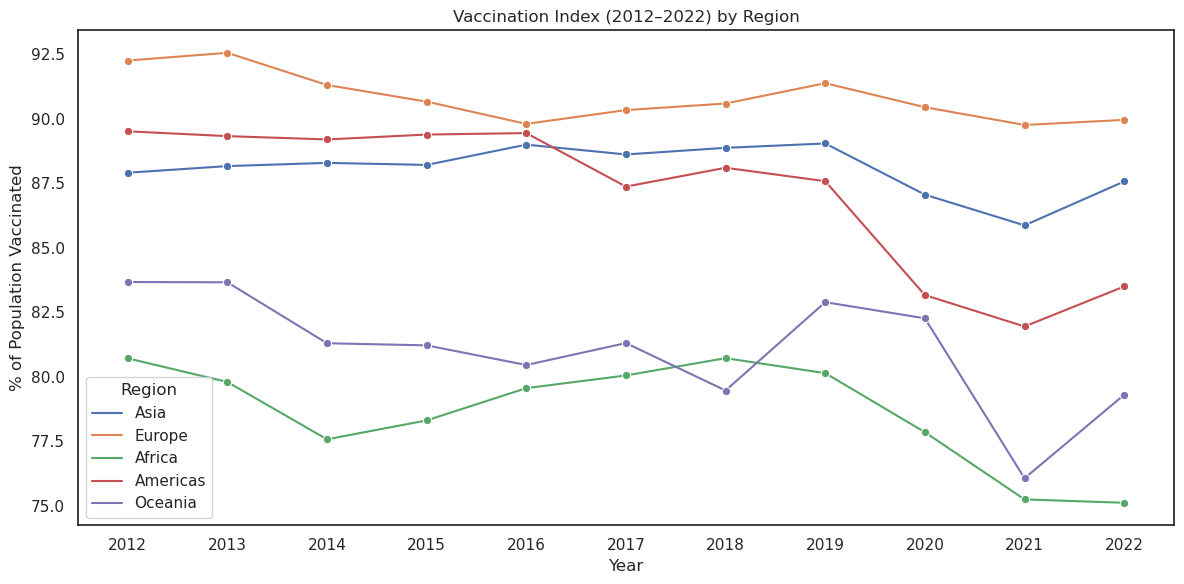

In [140]:
sns.lineplot(data=time_df, x='year', y='vac_index', hue='region', marker='o', errorbar=None)
plt.title('Vaccination Index (2012–2022) by Region')
plt.ylabel('% of Population Vaccinated')
plt.xlabel('Year')
plt.legend(title='Region')
plt.xticks(np.arange(2012, 2023, step=1))
plt.tight_layout()
plt.savefig('04_vaccinations_region_time.png', bbox_inches='tight')
plt.show()

It gets interesting here. All regions had vaccination drop from 2019 to 2021, as expected. Additionally, We can see the following patterns.
1. **Europe** - generally the highest vaccination rate - it doesn't drop below 90%. The highest drop took place from 2015 to 2017 (around 2.5%)
2. **Asia** - relatively stable vaccination rates (85%-90%), the only drop takes place in 2019.
3. **Americas** - Vaccination rates have started to drop in 2016 and the drastically from 2019.
4. **Oceania** - in Oceania vaccination rates have started to drop in 2013, than rapidly grow in 2019 to drop again in the COVID era. 
5. **Africa** - In Africa vaccination rates constantly grow since 2014 to 2018 (2.5%) and then drop drastically from 2019 to 2022, to less then 75% (lowest rate in 10 studied years).

Although there are differences between regional trends, it is hard to say the cause as variation between countries on continents might be huge. 

In [141]:
#creating function plotting subregional trends - one chart per region
def plot_region_trends(df, region_name):
    """
    Plots vaccination trends for a given region:
    - One line per subregion
    - One gray line for the region average
    
    Parameters:
    df (DataFrame): Your full dataset with columns: year, region, subregion, vac_index
    region_name (str): Name of the region to plot (must match df['region'])
    """

    region_df = df[df['region'] == region_name]
    
    plt.figure(figsize=(10, 5))
    
    sns.lineplot(data=region_df, x='year', y='vac_index', hue='subregion', estimator='mean', marker='o', 
                 palette="Set2", errorbar=None)
    sns.lineplot(data=region_df, x='year', y='vac_index', estimator='mean', color='grey', linewidth=10, 
                 alpha=0.4, label=f"{region_name} (avg)", errorbar=None)
    
    plt.title(f"Vaccination Index in {region_name} (2012–2022)", fontsize=14)
    plt.ylabel('% of Population Vaccinated')
    plt.xlabel('Year')
    plt.legend(title='Subregion')
    plt.xticks(np.arange(2012, 2023, step=1))
    plt.ylim(60, 100)
    plt.tight_layout()
    plt.savefig(f"04_vaccinations_{region_name}", bbox_inches='tight')
    plt.show()

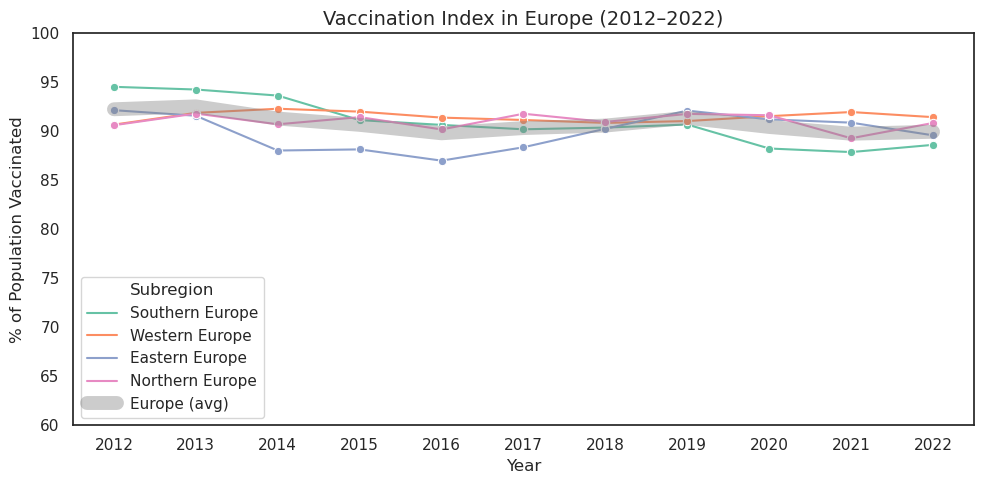

In [142]:
plot_region_trends(time_df, "Europe")

Generally in Europe there is high vaccination score fluctuating between 85% and 95%. While Eastern Europe had the lowest score in 2014-2017, it rised in 2019 and remained stable during covid_19 pandemic. In Southern Europe there was a slight drop in vaccinations after 2019 and in Northern Europe after 2020 (northern regions were affected by covid_19 later in the year). 

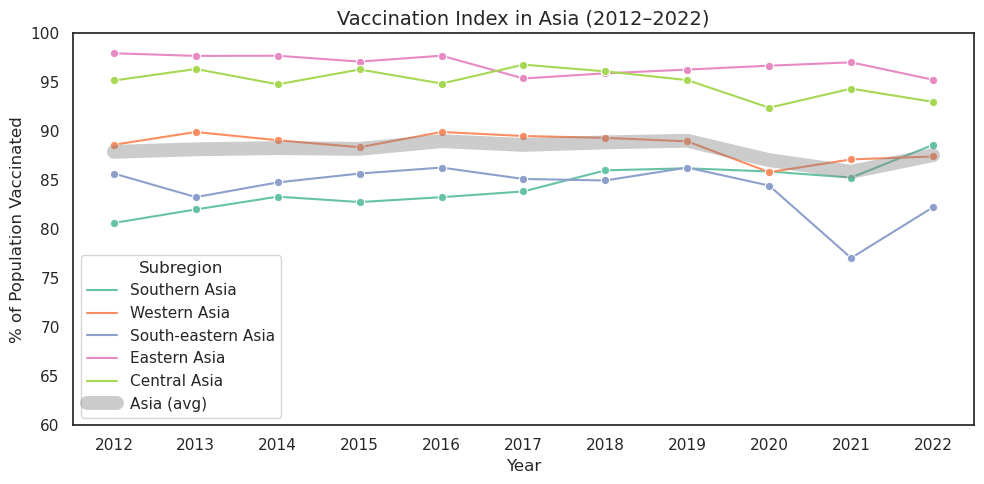

In [30]:
plot_region_trends(time_df, "Asia")

In Asia region there is a higher variation:
- **Eastern and Central Asia** had high vaccination score over the years (around 95%). In Central Asia there was a slight drop in 2018-2020, growing and stabilizing again in 2021.
- **Western Asia** countries % of vaccinated population is relatively stable, between 85-90%, with a slight drop in 2020
- **Southern and South-eastern Asia** both used to have the smallest vaccination score, between 82 and 87%. However in Southern Asia the % of vaccinated population had been slowly but constantly growing over the years, being stable in years 2019-2021 and reaching over 90% in 2022. At the same time immunization score in South-east Asia has been stable, dropping drastically in 2021 to around 77%, and rising to 80% in 2022. 

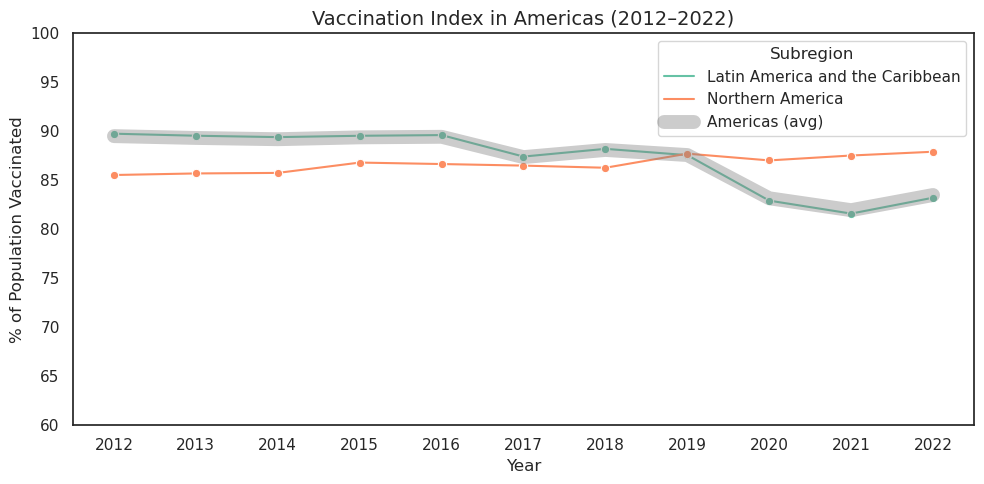

In [143]:
plot_region_trends(time_df, "Americas")

As the majority of countries in American region is part of **Latin America and Caribbean**, the trend for this region matches almost perfectly the line for the whole region. The immunization score in this sub-region was almost 90% (higher than North America) in 2012-2016, and then has started to drop in 2017 (probable explanation - due to political and economic crisis in many countries in sub-region), with the lowest point in 2021 (around 82%). At the same time % of population vaccinated in **Northern America** has been stable over the years (around 85-87%), with no drop in 2019-2021.

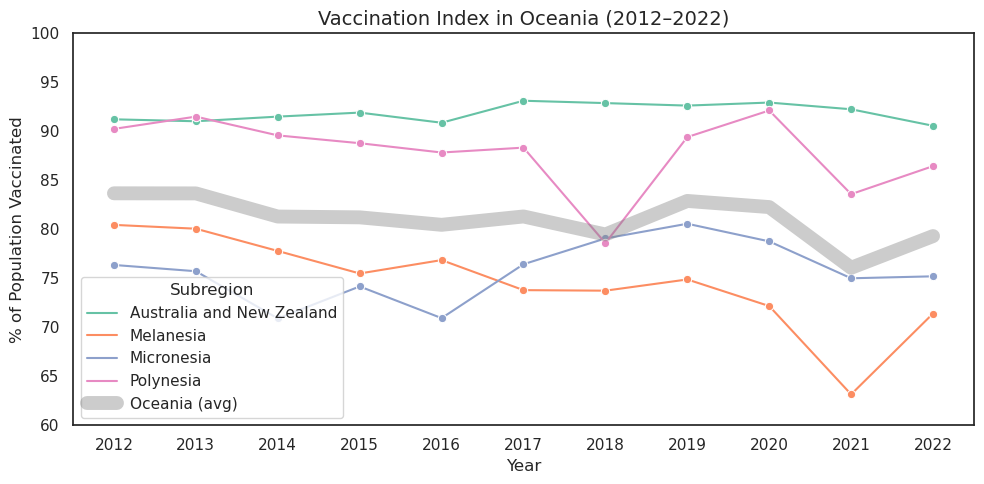

In [144]:
plot_region_trends(time_df, "Oceania")

There is very high variation of a vaccination score in the Oceania region:
- **Australia and New Zealand** keeps the % of immunized population high, above 90%
- **Polynesia** - in this sub-region the core was high (between 90% and 95%) till 2018, when it dropped to 80%. The drop was probably caused by the huge anti-vaccine movement in Samoa after 2 babies dying out of using expired ingredients in vaccine mixtures (see below table). The score rised again in 2019 and have dropped in 2021 to 85% again.
- **Micronesia** - the % of people immunized has been growing from around 81% in 2012 to 85% in 2019, and then dropping to 80% again in 2021
- **Melanesia** - in the Melanesia sub-region vaccination score has been dropping since 2012 (80%) to 75% in 2019, and the reaching massive drop in 2021 (less than 65%), reaching 70% again in 2022. Is is most probably caused by low % of population vaccinated in Papua New Guinea (see 2nd table below), however it is not clear why the score has been dropping over the years (possible explanations: low-quality data, widespread population and difficult to reach, drug scandal).

In [33]:
pol18 = time_df[(time_df['subregion']=="Polynesia") & (time_df['year']==2018)]
pol18[['country', 'year', 'vac_index']].sort_values(by="vac_index").head(3)

country  year  vac_index
1227   Samoa  2018      46.38
1253  Tuvalu  2018      90.38
1249   Tonga  2018      99.00

In [34]:
mel = avg_df[(avg_df['subregion']=="Melanesia")]
mel[['country', 'vac_index']].sort_values(by='vac_index').head(3)

country  vac_index
128  Papua New Guinea      43.61
176           Vanuatu      78.41
151   Solomon Islands      80.60

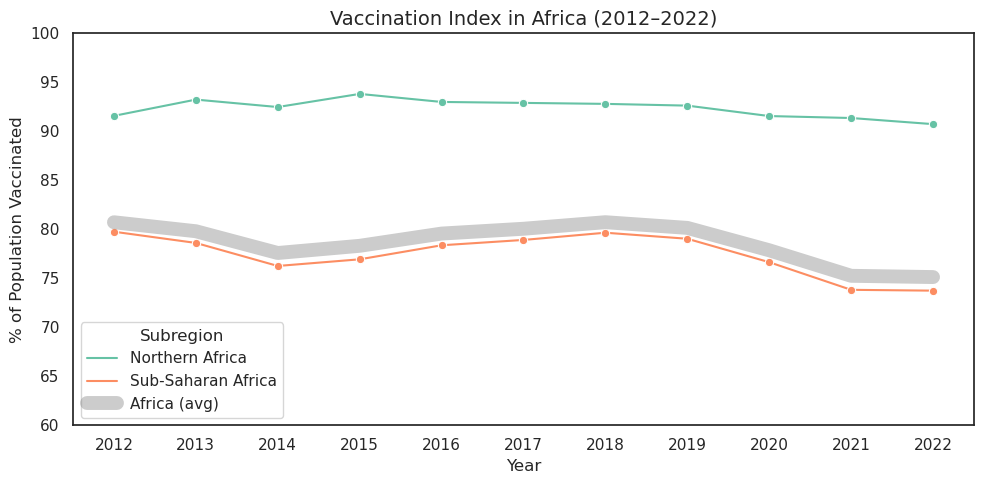

In [145]:
plot_region_trends(time_df, "Africa")

Generally **Sub-Saharian Africa** vaccination score is in line with the continent trend (a bit lower though) - fluctuating between 75% and 80%, dropping in 2014, then growing again over the years till 2018 to drop again in 2019-2021. **Northern Africa** score is much higher (above 90%) and stable over the years

#### Conclusions
1. There are continental variations in both - average vaccination scores and time trends
2. Some sub-regions on continents are more homogenic (Europe), whereas the other vary widely (Oceania)
3. Regional analysis revealed that % of population vaccinated can be impacted by various factors e.g. health investments, government type, historical influences, economic and political crisis, wars, health staff mistakes, spread of the population,  etc. It would be useful to include additional indicators in future analysis. 

## GDP

#### Correlation

In [128]:
def calculate_corr (variable):
    """
    Calculates and prints Pearson correlation coefficient (r) for a given variable and a vaccination score toghether with p-value.
    
    Parameters:
    variable: name of a variable in the avg_df dataframe
    """
    r, p_value = pearsonr(avg_df[variable], avg_df['vac_index'])

    print(f"Pearson r: {r}")
    print(f"P-value: {p_value}")

In [129]:
#calling correlation function
calculate_corr ('gdp')

Pearson r: 0.3247333619140635
P-value: 8.194248044275013e-06


There is statistically significant low positive relationship between gdp per capita and vaccination score.

#### Regression

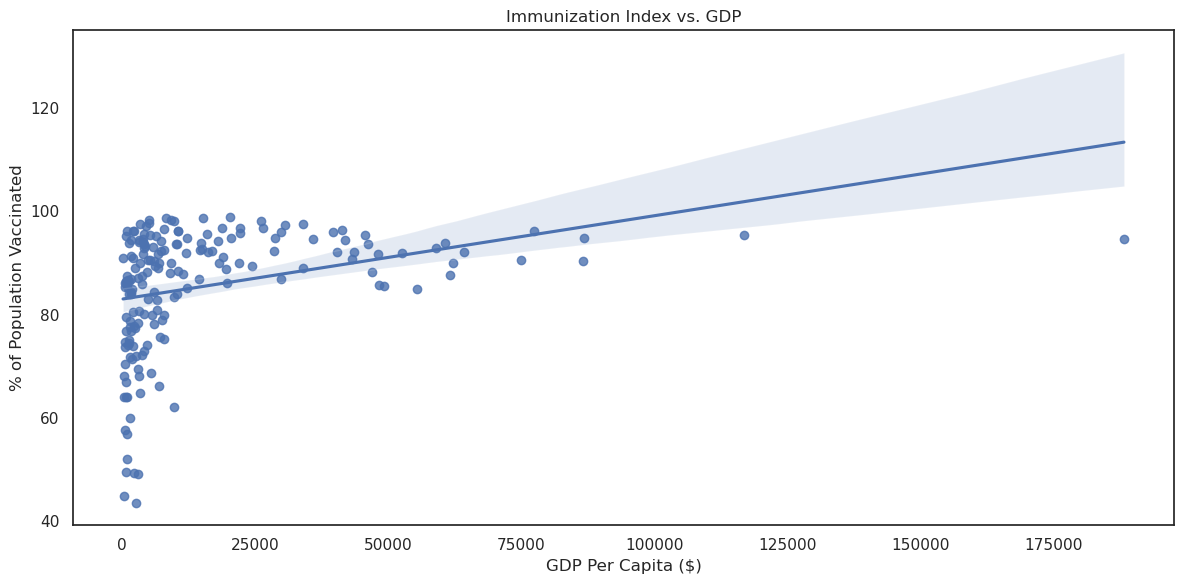

In [146]:
#creating line plot
sns.regplot(data=avg_df, x='gdp', y='vac_index', ci=95)

#setting up title and axis names
plt.title('Immunization Index vs. GDP')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("GDP Per Capita ($)")

plt.tight_layout()
plt.savefig('05_gdp_regression.png', bbox_inches='tight')
plt.show()

Correlation of gdp and vaccination score is not high, however, there is a pattern. From certain gdp threshold, the average vaccination score do not drop below 80%. Thus, countries with high gdp will always have relatively high % of population immunized. Countries with lower gdp on the other side can have high or low vaccination score depending on different factors. Let's have a closer look and the relationship without outliers:

In [38]:
# Calculate Pearson correlation and p-value
r, p_value = pearsonr(df_avg_cleangdp['gdp'], df_avg_cleangdp['vac_index'])

print(f"Pearson r: {r}")
print(f"P-value: {p_value}")

Pearson r: 0.43591256225325653
P-value: 8.338939707145611e-09


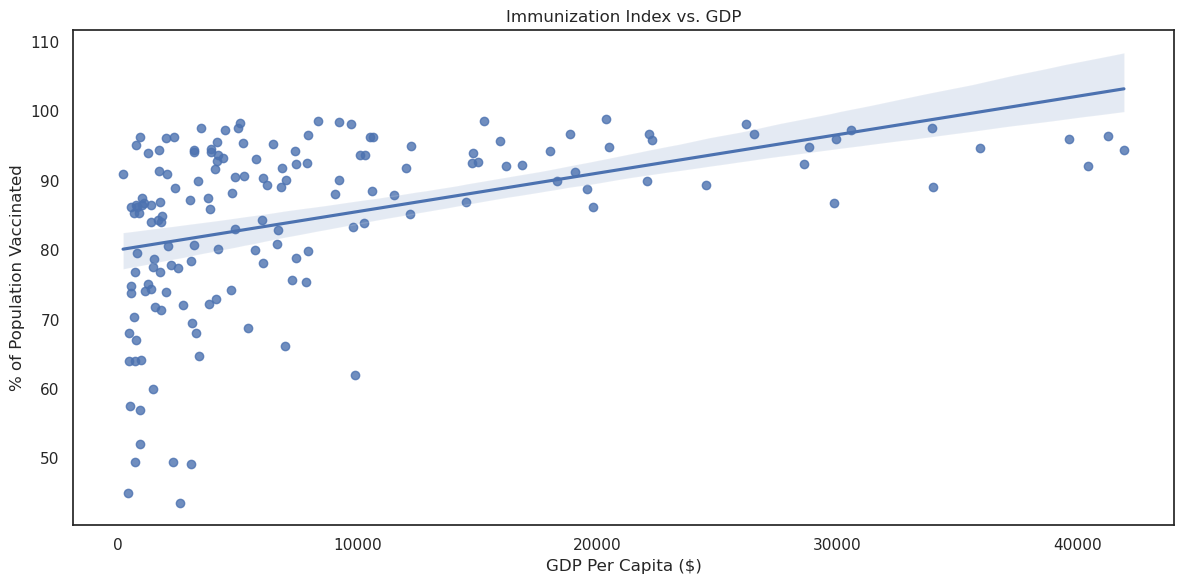

In [147]:
#creating line plot
sns.regplot(data=df_avg_cleangdp, x='gdp', y='vac_index', ci=95)

#setting up title and axis names
plt.title('Immunization Index vs. GDP')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("GDP Per Capita ($)")

plt.tight_layout()
plt.savefig('05_gdp_clean_regression.png', bbox_inches='tight')
plt.show()

Clearly, countries with gdp per capita higher than 10,000$ (with one exception) have average vaccination score between 80 and 100%. Below this threshold, the variance is much higher, with the probability of lower vaccination score being higher the lower the gdp per capita is. Many countries with a low gdp though, have high vaccination scores.

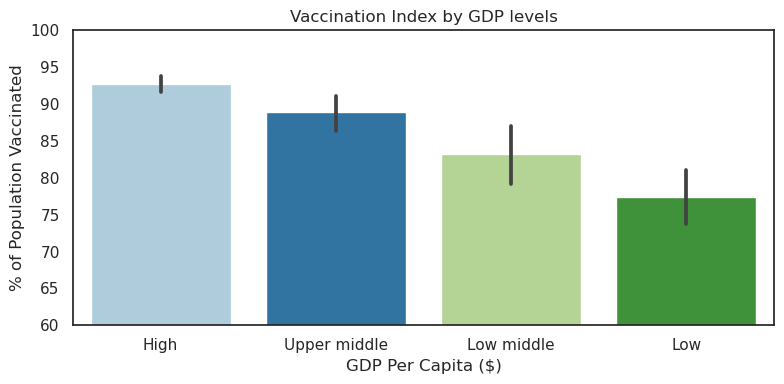

In [148]:
#creating bins to compare immunization for different gdp countries
avg_df['gdp level'] = pd.qcut(avg_df['gdp'], q=4, labels=['Low', 'Low middle', 'Upper middle', 'High'])

plt.figure(figsize=(8, 4))

#creating a bar plot
sns.barplot(data=avg_df, x="gdp level", y="vac_index", estimator='mean', order = ['High', 'Upper middle', 'Low middle', 'Low'], palette="Paired")

plt.title('Vaccination Index by GDP levels')
plt.ylabel('% of Population Vaccinated')
plt.xlabel('GDP Per Capita ($)')
plt.ylim(60, 100)

plt.tight_layout()
plt.savefig('05_gdp_levels.png', bbox_inches='tight')
plt.show()

#### Time Trends

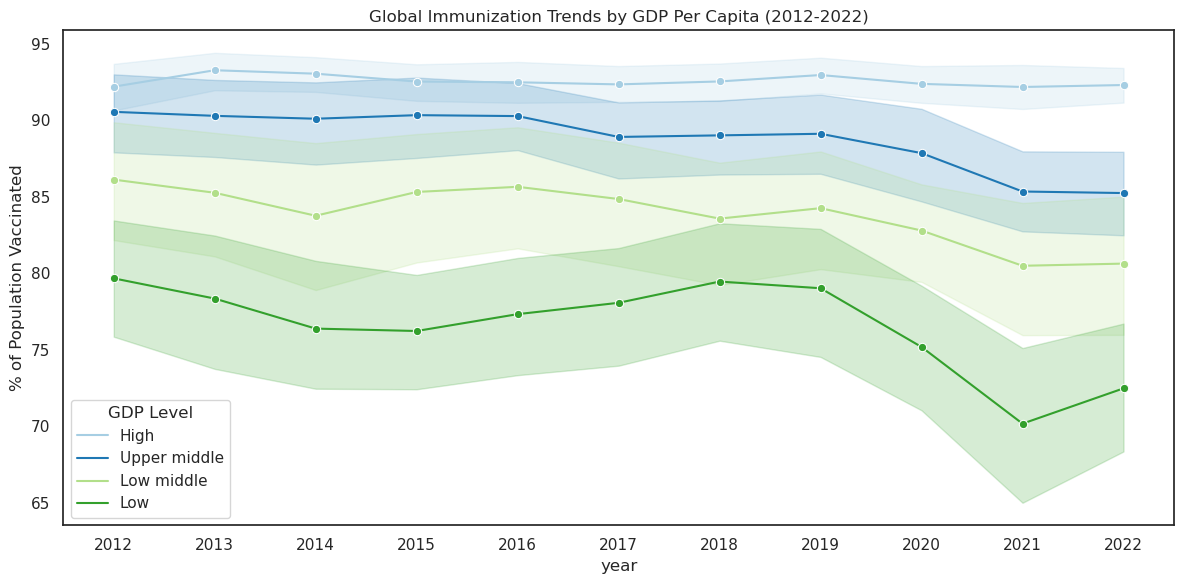

In [149]:
#creating bins to compare immunization for different gdp countries
time_df['gdp level'] = pd.qcut(time_df['gdp'], q=4, labels=['Low', 'Low middle', 'Upper middle', 'High'])

#creating line plot
sns.lineplot(data=time_df, x='year', y='vac_index', estimator='mean', marker='o', hue='gdp level', 
             hue_order = ['High', 'Upper middle', 'Low middle', 'Low'], palette="Paired")

#setting up title and axis names
plt.title('Global Immunization Trends by GDP Per Capita (2012-2022)')
plt.ylabel("% of Population Vaccinated")
plt.legend(title='GDP Level')

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()
plt.savefig('05_gdp_time.png', bbox_inches='tight')
plt.show()

I expected the highest drop for high gdp countries due to forced vaccination policies but it the highest drop is for low gdp countries. Intrestingly trends are a bit different for each gdp level:

1. **High gdp** - vaccination index always above 90%, almost no fluctuations
2. **Upper-middle gdp** -  immunization score above 90% till 2016, and then started to drop (before COVID_19) till 2021, stabilizing in 2022 around 87%. What was the cause?
3. **Low-middle gdp** - there are regular fluctuations around 85% with the most recent drop after 2019 to 82-83% in 2022 
4. **Low gdp** - immunization score increasing constantly from 2015 till 2018 and then dropped drastically from 2019 to 2021 (around 10%) and then rised again in 2022. Was this drop caused by inefficiency of the health care system? Maybe programs ensuring vaccinations shifted their fundings to COVID-19?

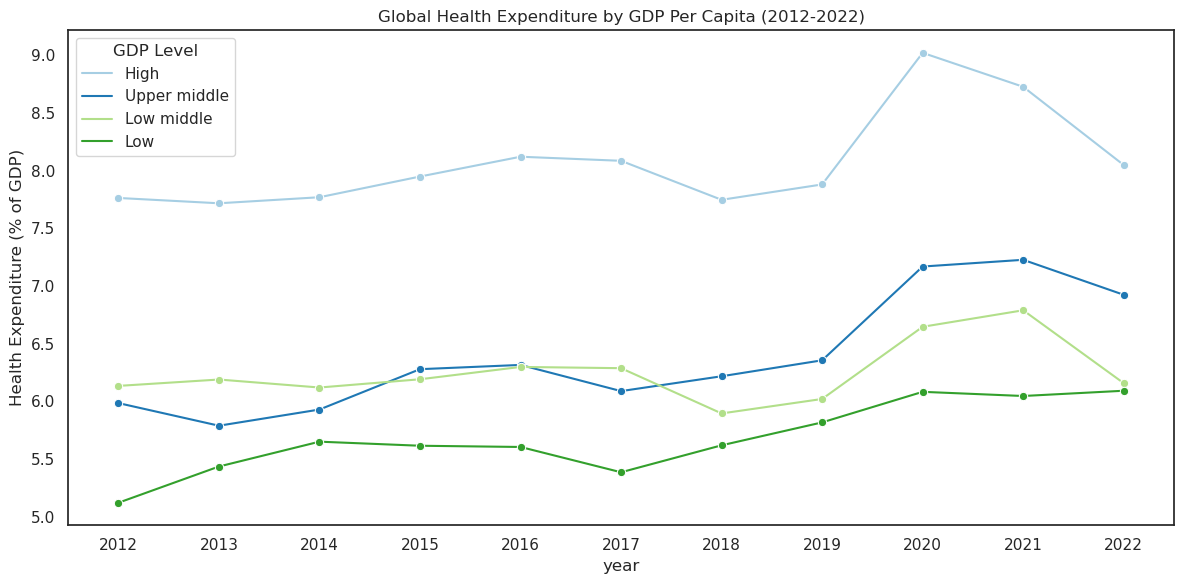

In [42]:
#creating line plot
sns.lineplot(data=time_df, x='year', y='health_exp', estimator='mean', marker='o', hue='gdp level', 
             hue_order = ['High', 'Upper middle', 'Low middle', 'Low'], palette="Paired", errorbar=None)

#setting up title and axis names
plt.title('Global Health Expenditure by GDP Per Capita (2012-2022)')
plt.ylabel("Health Expenditure (% of GDP)")
plt.legend(title='GDP Level')

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()
plt.show()

As expected - generally the higher gdp per capita, the higher % of gdp is shifted to health funding. Health expediture rised in all countries since 2019 (the least in low gdp countries, the highest in high gdp countries). Probable explanation - vast majority countries rised financing towards heathcare system to manage covid_19 needs. Whereas countries with higher gdp managed to keep routine vaccinations programs stable, countries with lower gdp struggled to vaccinate children due to lack of funding or lockdown (with the vaccination score in low-gdp countries being impacted the most). 

## Children Mortality

#### Correlation

In [130]:
calculate_corr ('child_mort')

Pearson r: -0.6939556750362128
P-value: 2.4857615584274427e-27


There is a statistically significant high negative correlation between % of people being vaccinated and children under age 5 mortality.

#### Regression

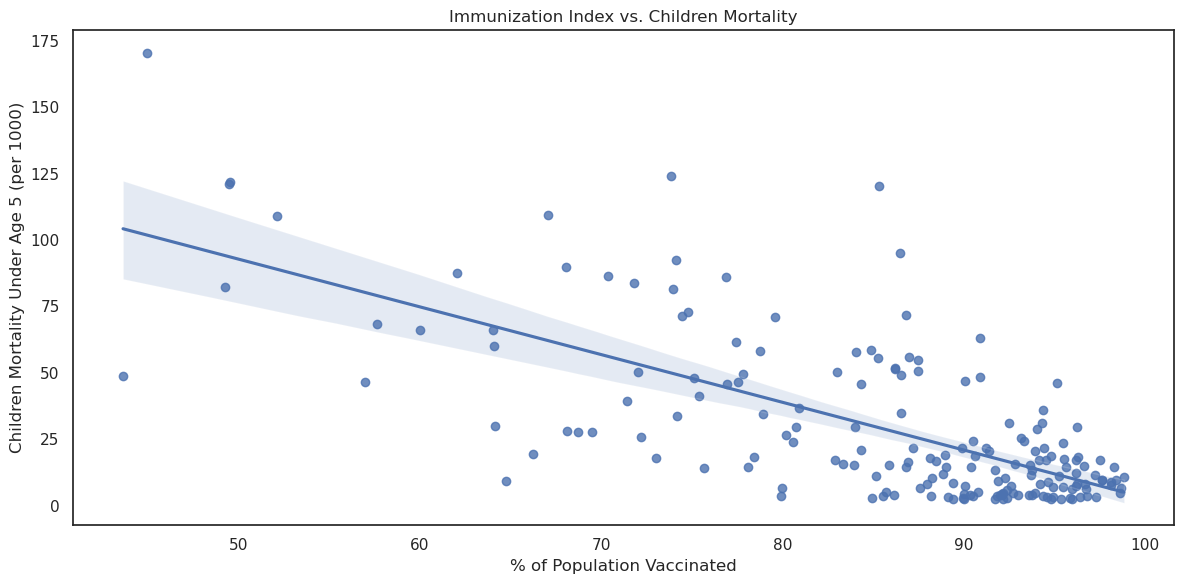

In [150]:
#creating line plot
sns.regplot(data=avg_df, y='child_mort', x='vac_index', ci=95)

#setting up title and axis names
plt.title('Immunization Index vs. Children Mortality')
plt.xlabel("% of Population Vaccinated")
plt.ylabel("Children Mortality Under Age 5 (per 1000)")

plt.tight_layout()
plt.savefig('06_childmortality_regression.png', bbox_inches='tight')
plt.show()

Children mortality is unlikely a predictor of a vaccination score, so it will be excluded from modeling and it is treated here as dependent/control variable. There is a strong relation between 2 variables (0.7), the higher % of population is vaccinated, the lower the mortality rate. The children mortality rate can be treated as well as a sign of efficiency of the healthcare system, so the relationship, as expected, is - the more efficient healthcare system, the higher immunization score.

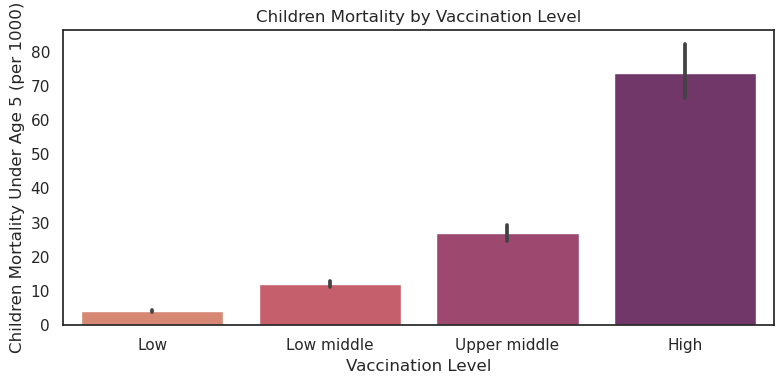

In [151]:
#creating bins to compare immunization for different children mortality countries
avg_df['vac level'] = pd.qcut(avg_df['child_mort'], q=4, labels=['Low', 'Low middle', 'Upper middle', 'High'])

plt.figure(figsize=(8, 4))

#creating a bar plot
sns.barplot(data=avg_df, x="vac level", y="child_mort",  estimator='mean', palette="flare")

plt.title('Children Mortality by Vaccination Level')
plt.xlabel('Vaccination Level')
plt.ylabel('Children Mortality Under Age 5 (per 1000)')

plt.tight_layout()
plt.savefig('06_childmortality_levels.png', bbox_inches='tight')
plt.show()

## Internet use

#### Correlation

In [131]:
calculate_corr ('internet_use')

Pearson r: 0.609593070053973
P-value: 8.4685152514037e-20


There is statistically significant moderate positive relationship between internet use and vaccination score.

#### Regression

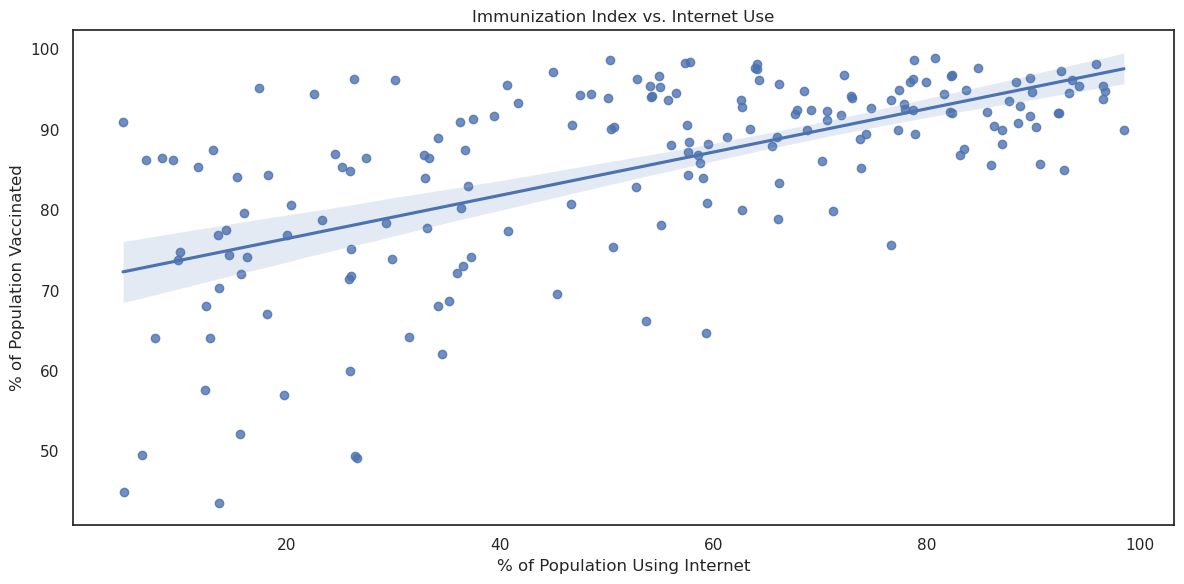

In [152]:
#creating line plot
sns.regplot(data=avg_df, x='internet_use', y='vac_index', ci=95)

#setting up title and axis names
plt.title('Immunization Index vs. Internet Use')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("% of Population Using Internet")

plt.tight_layout()
plt.savefig('07_internet_regression.png', bbox_inches='tight')
plt.show()

Internet use have one of the highest linear relationships with the vaccination score, stronger than gdp, however less obvious. There are few points for a discussion:
1. **Why is the relationship that strong?** Internet might be a good indicator of urbanization and development. There is better access to information (thus campaigns), digital public health infrastructure (easier vaccine registration)
2. **Why some countries with low internet use have very high vaccination score?** Lets have a look at those countries to find out:

In [48]:
low_int = avg_df[avg_df['internet_use'] < 20]
low_int[["region", "subregion","country", "vac_index", "internet_use"]].sort_values("vac_index", ascending=False).head(10)

region           subregion       country  vac_index  internet_use
137  Africa  Sub-Saharan Africa        Rwanda      95.18         17.45
27   Africa  Sub-Saharan Africa       Burundi      90.93          4.70
160  Africa  Sub-Saharan Africa      Tanzania      87.48         13.12
26   Africa  Sub-Saharan Africa  Burkina Faso      86.47          8.36
98   Africa  Sub-Saharan Africa        Malawi      86.22          9.35
169  Africa  Sub-Saharan Africa        Uganda      86.19          6.86
147  Africa  Sub-Saharan Africa  Sierra Leone      85.34         11.73
86   Africa  Sub-Saharan Africa         Kenya      84.32         18.30
179  Africa  Sub-Saharan Africa        Zambia      84.08         15.34
163  Africa  Sub-Saharan Africa          Togo      79.60         16.00

All countries with the highest % of population vaccinated and low internet use, are from Sub-saharian Africa region, where many external organizations (like Gavi, the Vaccine Alliance, World Health Organization (WHO), UNICEF) implemented immunization programs. Good job people! Let's have a look at regional regression plot as well:

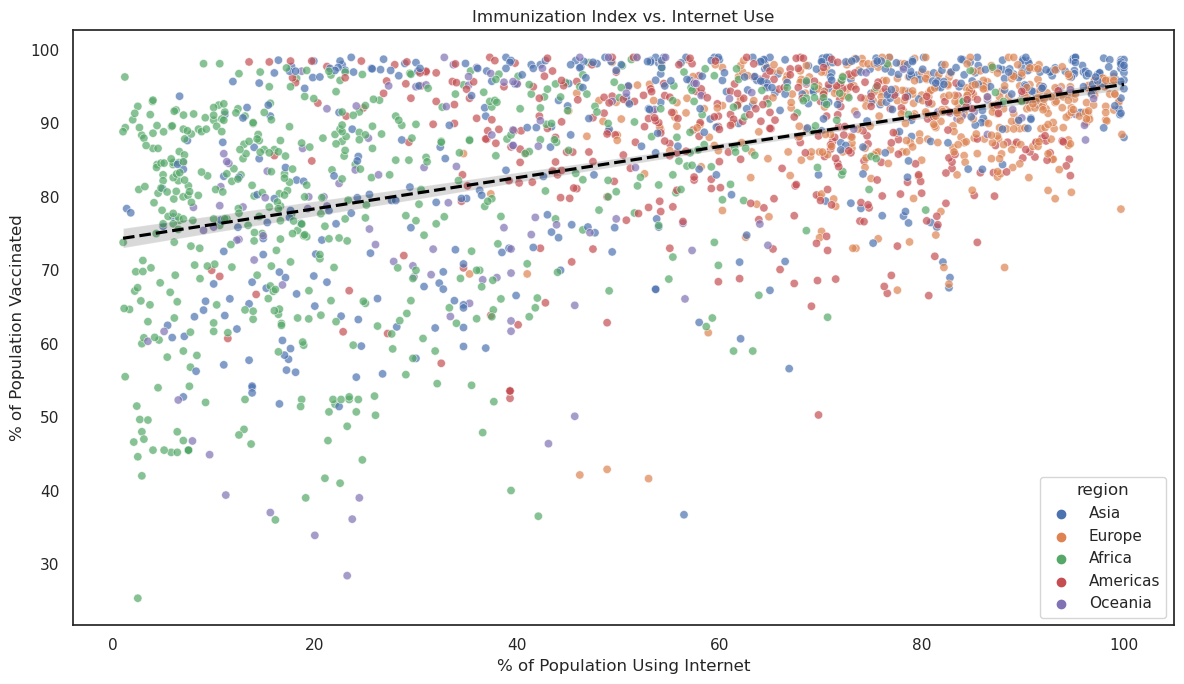

In [153]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df,x='internet_use', y='vac_index',hue='region', alpha=0.7)

sns.regplot(data=df, x='internet_use', y='vac_index', scatter=False, color='black', line_kws={'linestyle':'--'})

plt.title('Immunization Index vs. Internet Use')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("% of Population Using Internet")

plt.tight_layout()
plt.savefig('07_internet_regionalregression.png', bbox_inches='tight')
plt.show()

It is clear, that countries with lower internet use, are mostly from Africa and Asia, and there is high variation regarding vaccination score (from less than 30% to almost 100% of population vaccinated). Asia and Oceania countries are widespread on the scale. However, the higher the % of people using internet the higher representation of countries from Americas and Europe, and more and more people are immunized. 

#### Time Trends

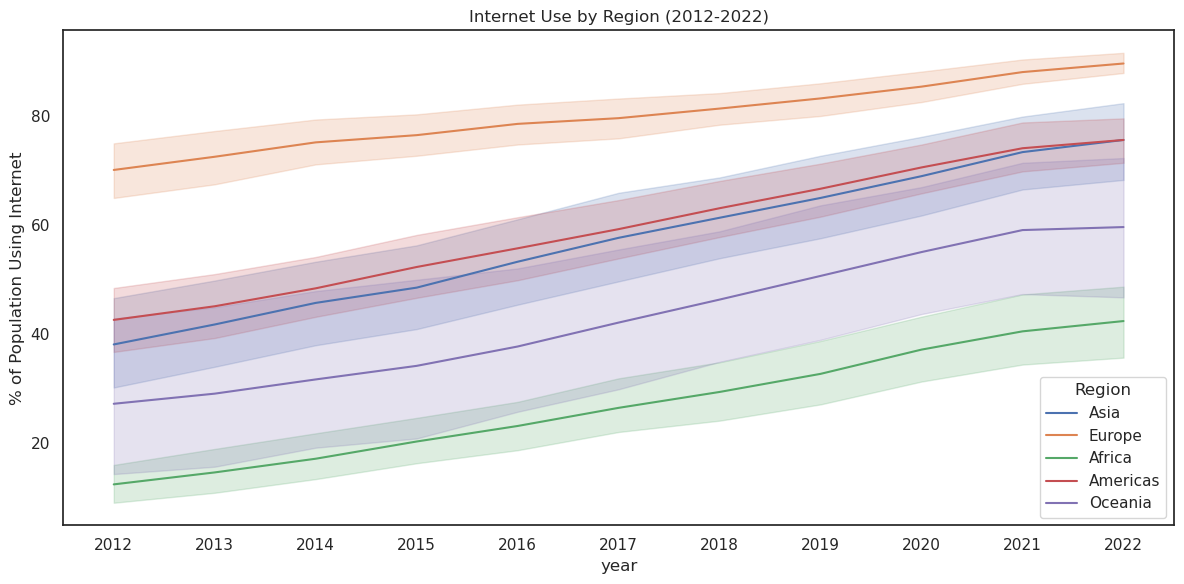

In [50]:
#creating line plot
sns.lineplot(data=time_df, x='year', y='internet_use', estimator='mean', hue='region')

#setting up title and axis names
plt.title('Internet Use by Region (2012-2022)')
plt.ylabel("% of Population Using Internet")
plt.legend(title='Region')

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()

plt.show()

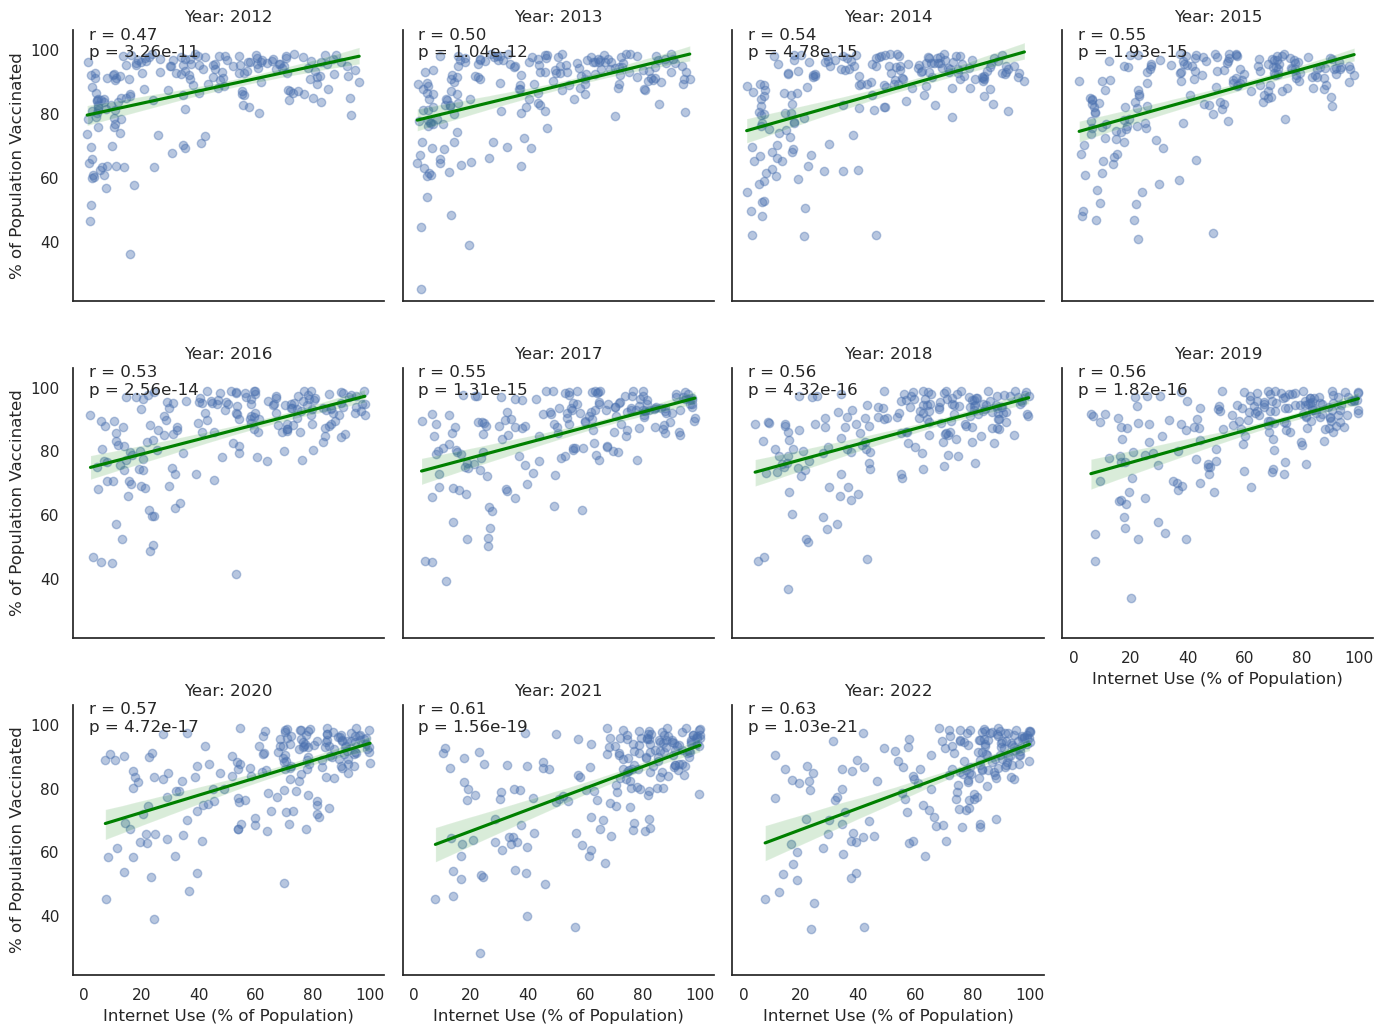

In [154]:
# Function to plot regression and add correlation
def add_corr(data, x, y, **kwargs):
    """Creates regression plot with a correlation coefficient and p value displayed on the top left corner"""
    
    #creating regression plot
    sns.regplot(data=data, x=x, y=y, scatter_kws={'alpha': 0.4}, line_kws={"color": "green"})

    # Calculate r and p-value
    r, p = pearsonr(data[x], data[y])

    # Display r and p on the plot
    plt.text(0.05, 0.9, f"r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes)

# Create the FacetGrid
g = sns.FacetGrid(time_df, col="year", col_wrap=4, height=3.5)
g.map_dataframe(add_corr, x="internet_use", y="vac_index")

# Set labels and layout
g.set_titles("Year: {col_name}")
g.set_axis_labels("Internet Use (% of Population)", "% of Population Vaccinated")
plt.tight_layout()
plt.savefig('07_internet_regressiontimeline.png', bbox_inches='tight')
plt.show()

The linear relationship of internet_use and vaccinations score gets stronger with time for 2 reasons:
1. More and more countries are getting more developed, thus more poeple use internet, and more get vaccinated. The reason is unclear, as mentioned above it is probably the influence of many factors.
2. Different factors, like economic crises, covid_19, etc. affect both - internet access and routine vaccinations access.

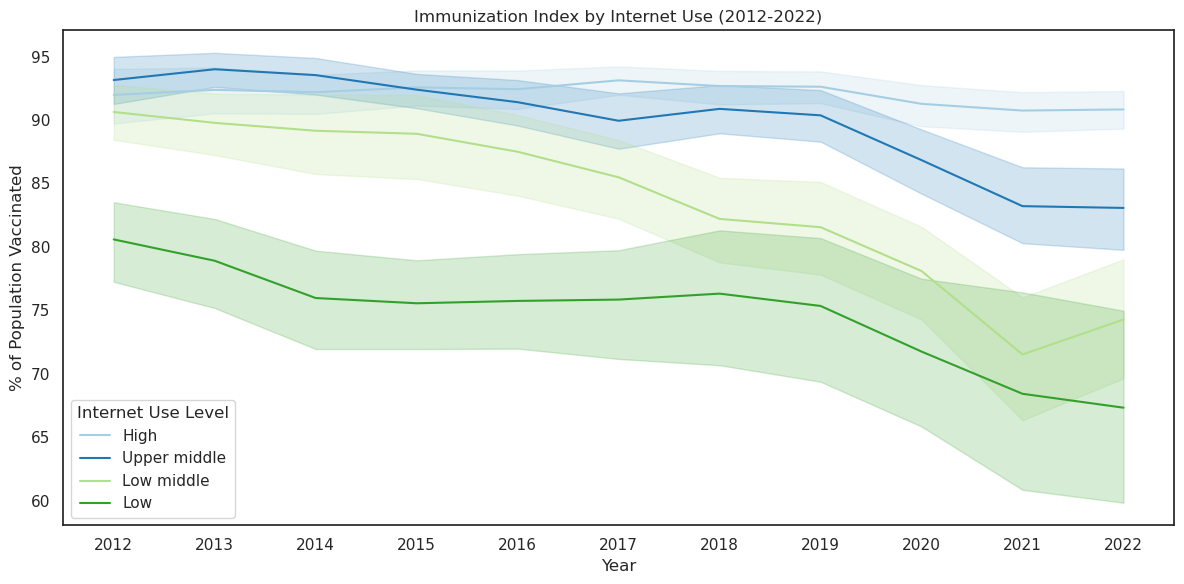

In [155]:
#creating bins to compare immunization for different internet use countries
time_df['internet_use_lvl'] = pd.qcut(time_df['internet_use'], q=4, 
                                      labels=['Low', 'Low middle', 'Upper middle', 'High'])

#creating line plot
sns.lineplot(data=time_df, x='year', y='vac_index', estimator='mean', hue='internet_use_lvl', 
             hue_order = ['High', 'Upper middle', 'Low middle', 'Low'], palette="Paired")

#setting up title and axis names
plt.title('Immunization Index by Internet Use (2012-2022)')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("Year")
plt.legend(title='Internet Use Level')

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()
plt.savefig('07_internet_time.png', bbox_inches='tight')
plt.show()

The are following patterns visible:
1. **High internet use** - vaccination score relatively stable
2. **Upper middle internet use** - extremely high vaccination score in 2012-2014, dropping to 90% in 2017, and then again in 2019
3. **Low middle internet use** - volatility, perhaps due to economic/political instability - vaccination score dropping gradually over the years, from 90% in 2012, to 83% in 2017, and 73% in 2021
4. **Low internet use** - consistent decline in vaccination scores - vaccination score has been dropping in years 2012 (80%) to 2015 (73%), then reaching around 77% in 2017, and then decreasing gradually to around 68% in 2021.

Only in countries with middle internet use in years 2019-2021 there was a significant drop in % of people immunized - high internet use countries remained stable, and in low internet use countries that was a continuation of an ongoing trend. 

**Diverging trends: Countries with lower internet use are falling behind, and this gap widens over time.**

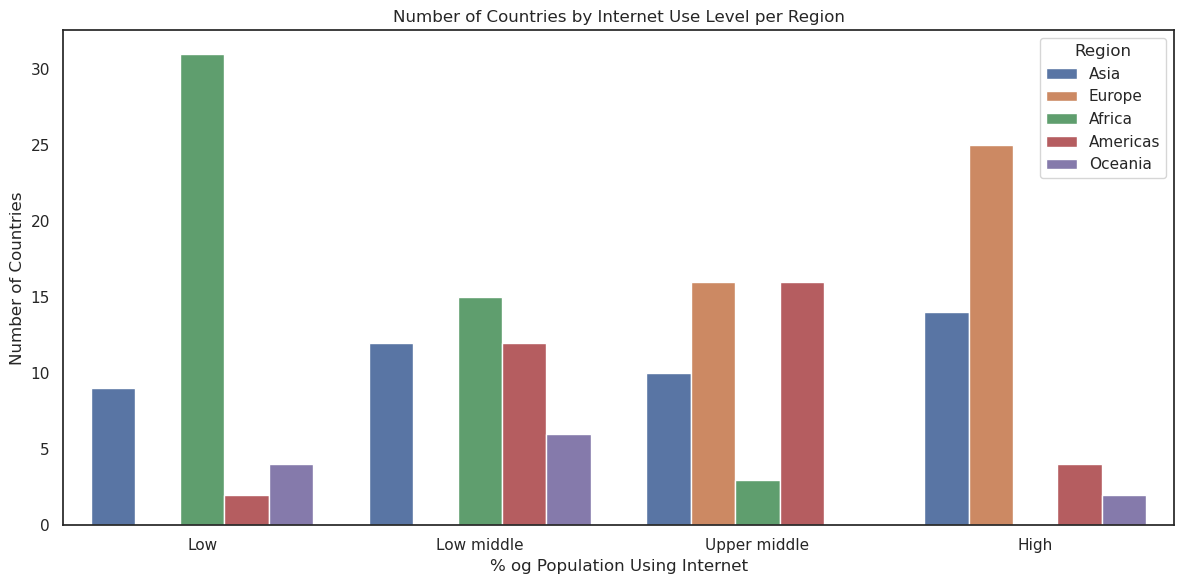

In [53]:
avg_df['internet_use_lvl'] = pd.qcut(avg_df['internet_use'], q=4, labels=['Low', 'Low middle', 'Upper middle', 'High'])

sns.countplot(data=avg_df, x="internet_use_lvl", hue="region")

plt.title('Number of Countries by Internet Use Level per Region')
plt.xlabel('% og Population Using Internet')
plt.ylabel('Number of Countries')
plt.legend(title='Region')

plt.tight_layout()
plt.show()

## Political Polarization

#### Correlation

In [54]:
pol_avg = avg_df.dropna(subset=['polarization'])

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(pol_avg['polarization'], pol_avg['vac_index'])

print(f"Pearson r: {r}")
print(f"P-value: {p_value}")

Pearson r: 0.23357703741740876
P-value: 0.0026114681980557025


The relationship is between political polarization and vaccination index is statistically significant but weak.

#### Regression

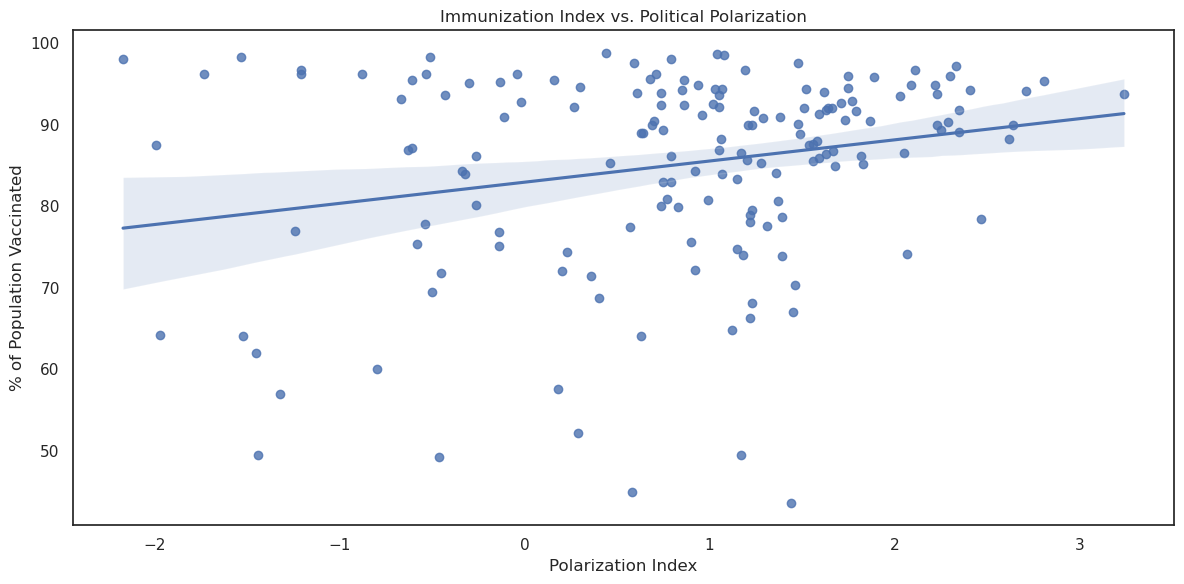

In [156]:
#creating line plot
sns.regplot(data=avg_df, x='polarization', y='vac_index', ci=95)

#setting up title and axis names
plt.title('Immunization Index vs. Political Polarization')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("Polarization Index")

plt.tight_layout()
plt.savefig('08_polarization_regression.png', bbox_inches='tight')
plt.show()

#### Time Trends

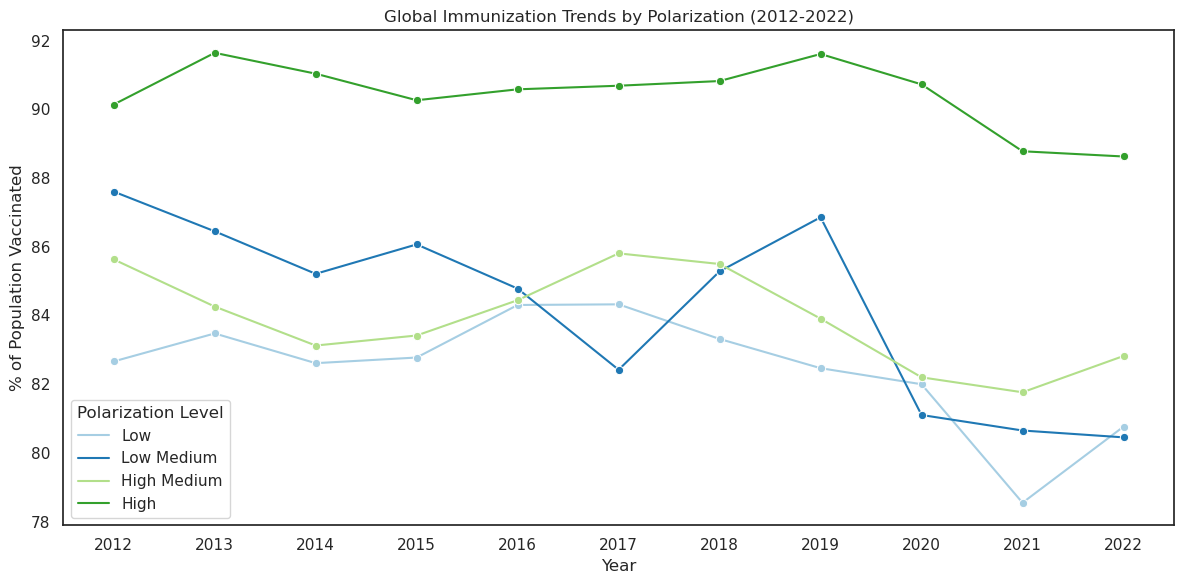

In [157]:
#creating bins to compare immunization for different polarization level
time_df['polarization level'] = pd.qcut(time_df['polarization'], q=4, labels=['Low', 'Low Medium', 'High Medium', 'High'])

#creating line plot
sns.lineplot(data=time_df, x='year', y='vac_index', estimator='mean', hue='polarization level', marker='o', palette="Paired", errorbar=None)

#setting up title and axis names
plt.title('Global Immunization Trends by Polarization (2012-2022)')
plt.ylabel("% of Population Vaccinated")
plt.xlabel("Year")
plt.legend(title='Polarization Level')

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()
plt.savefig('08_polarization_time.png', bbox_inches='tight')
plt.show()

Countries with high polarization level have much higher vaccination score than countries with lower polarization. It might be caused by different factors, though, lets have a look at gdp:

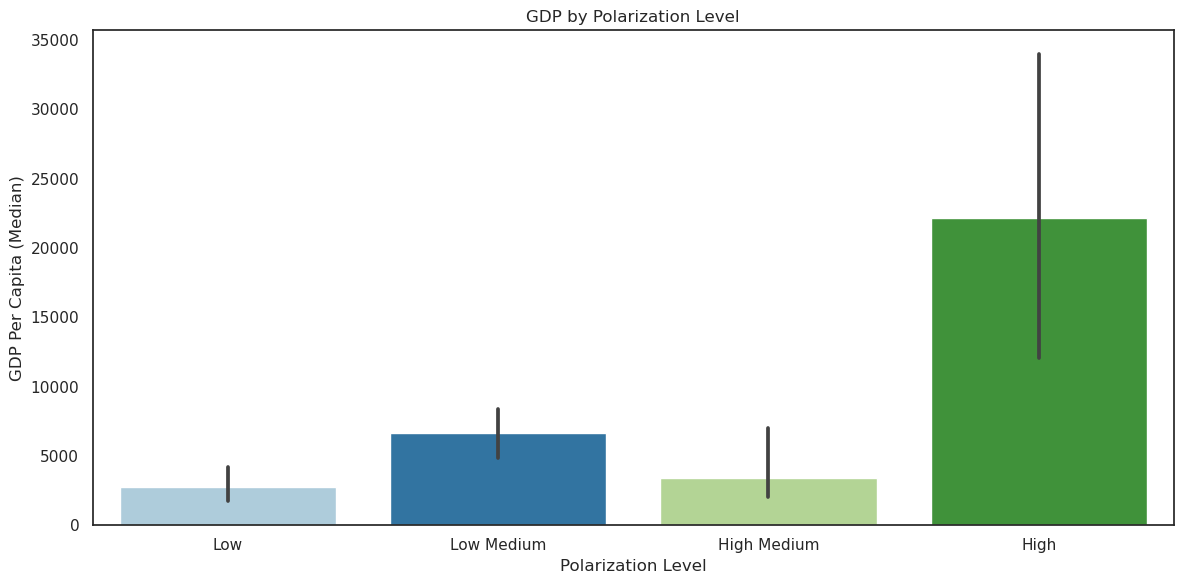

In [158]:
#creating bins to compare immunization for different polarization level
avg_df['polarization level'] = pd.qcut(avg_df['polarization'], q=4, labels=['Low', 'Low Medium', 'High Medium', 'High'])

#creating bar plot
sns.barplot(data=avg_df, x='polarization level', y='gdp', estimator='median', palette="Paired")

#setting up title and axis names
plt.title('GDP by Polarization Level')
plt.ylabel("GDP Per Capita (Median)")
plt.xlabel("Polarization Level")

plt.tight_layout()
plt.savefig('08_polarization_levels.png', bbox_inches='tight')
plt.show()

Countries with high gdp per capita (median) generally have higher polarization score. Trends visible on previous plot likely are a result of the fact, that highly developed countries are stronger politically polarized. 

## Trust in Government (OECD)

In [58]:
#removing missing rows
oecd_avg_df = avg_df.dropna(subset=['gov_trust'])
oecd_time_df = time_df.dropna(subset=['gov_trust'])

In [59]:
oecd_avg_df.shape

(38, 20)

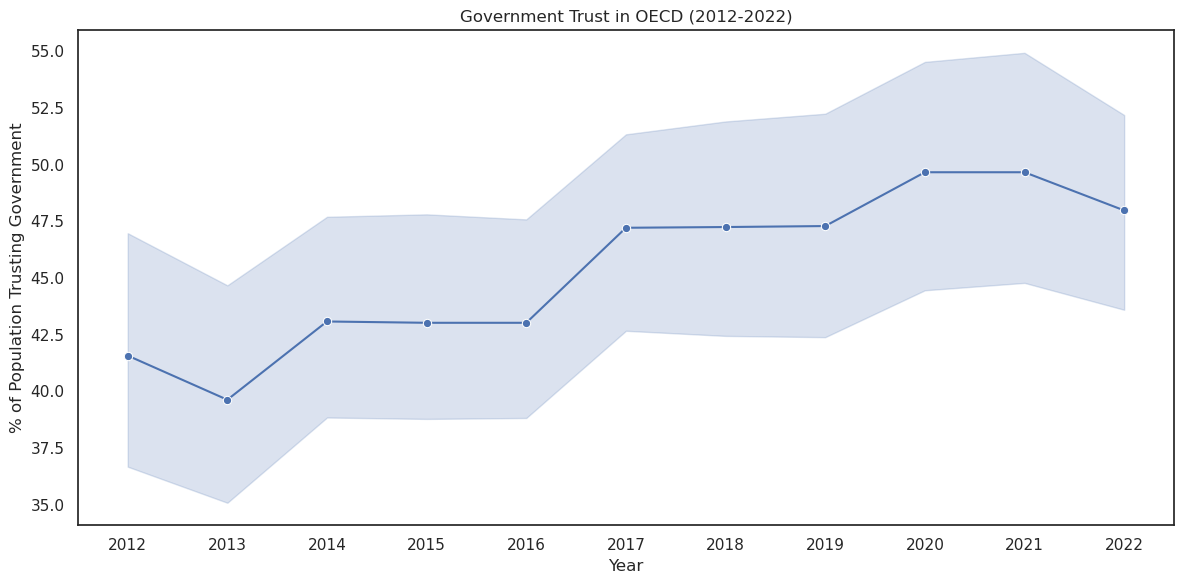

In [60]:
#creating line plot
sns.lineplot(data=oecd_time_df, x='year', y='gov_trust', estimator='mean', marker='o')

#setting up title and axis names
plt.title('Government Trust in OECD (2012-2022)')
plt.ylabel("% of Population Trusting Government")
plt.xlabel("Year")

#setting up ticks and ranges for clarity
plt.xticks(np.arange(2012, 2023, step=1))

plt.tight_layout()
plt.show()

Data for government trust is available for OECD countries only. Generally trust towards government constantly grown except the recent drop in 2021-2022. It is a first drop since 2012. 

In [61]:
# Calculate Pearson correlation and p-value
r, p_value = pearsonr(oecd_avg_df['polarization'], oecd_avg_df['vac_index'])

print(f"Pearson r: {r}")
print(f"P-value: {p_value}")

Pearson r: 0.10668942384020072
P-value: 0.5237786051513494


When looking at aggregations the government trust is weak and insignificant. However, this relationship changes over time:

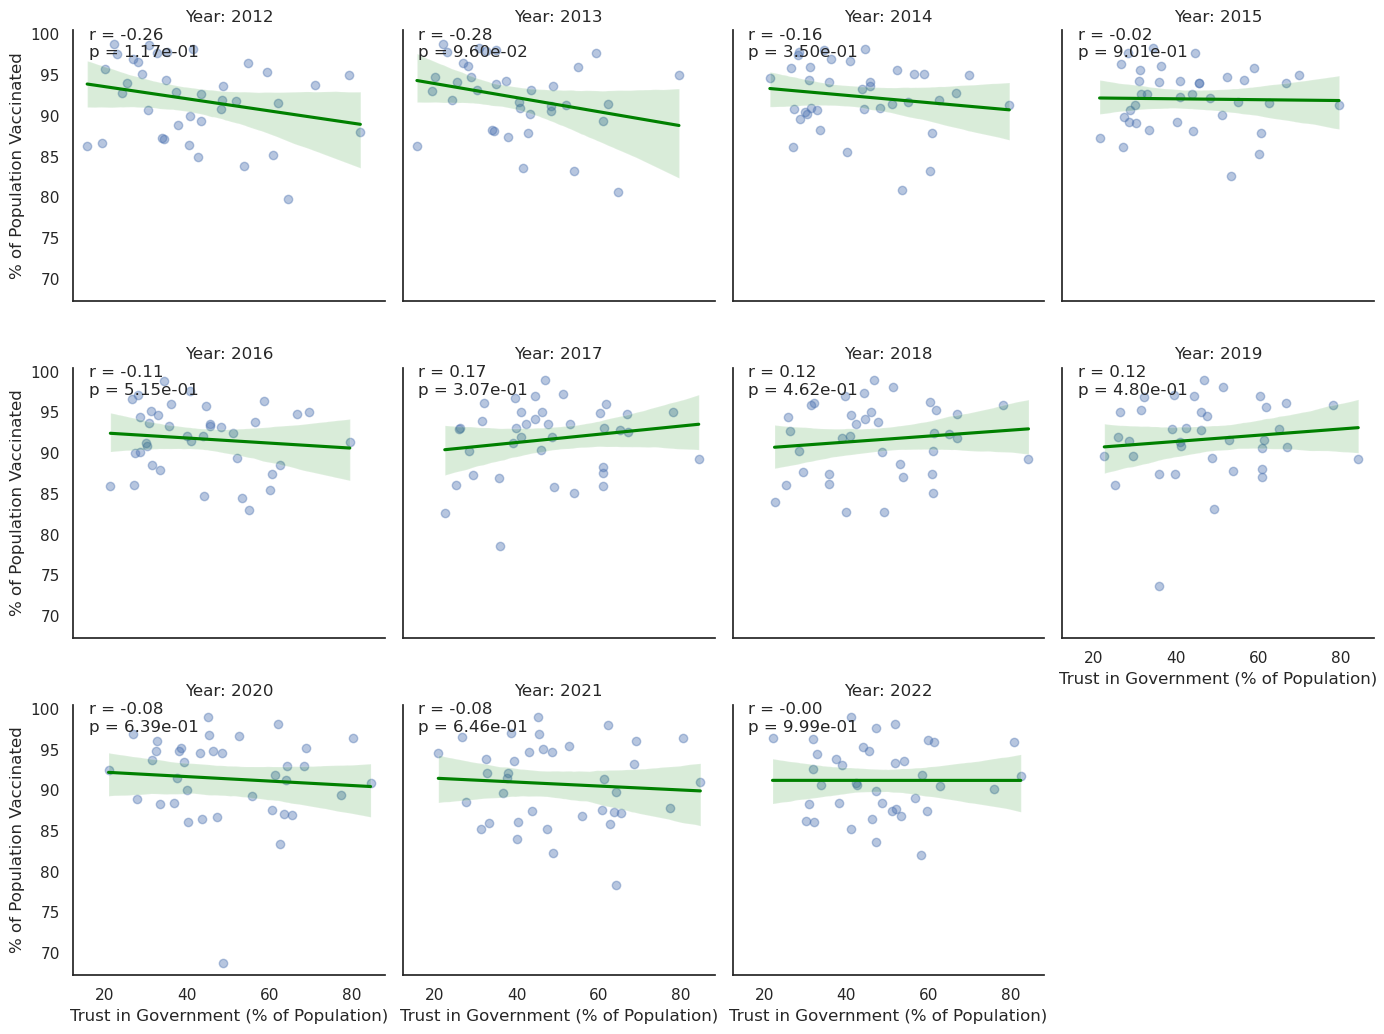

In [62]:
# Set up FacetGrid and calling correlation add function
g = sns.FacetGrid(oecd_time_df, col="year", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(add_corr, x="gov_trust", y="vac_index")

# Titles and layout
g.set_titles("Year: {col_name}")
g.set_axis_labels("Trust in Government (% of Population)", "% of Population Vaccinated")
plt.tight_layout()
plt.show()

Although the relationship of those 2 variables seems to be interesting as it changes with time (in early 10' it was negative, then it started to get less and less strong, even changing direction reaching 0.17 in 2017, and weakening again), it is not statistically significant. There are only 38 countries included, so that might be the cause. It is worth exploring with a wider dataset. 

# Conclusions

This exploratory analysis reveals several important insights:

1. Globally, % of population vaccinated is quite stable. There was a significant drop (around 5%) in immunization in 2019 till 2021. In 2022 immunization score increased. This is likely lined with the COVID-19 epidemic.
2. Internet use, originally included as a potential factor causing recent vaccination decrease in richer nations, happened to be the strongest correlator (0.7) of vaccination index generally. It suggests, that urbanization, development and information access, might strongly influence immunizations.
3. While economic development matters, it's not the whole story. In wealthiest countries always high % of population is immunized, but the rest of the world is highly differentiated. Some lower-income countries outperform wealthier peers, indicating that government control, effective health policies, social acceptance and community engagement, may offset economic constraints.
4. The biggest challenges we seem to currently face when keeping our societies vaccinated, are resilience during conflicts and crises times, geographical barriers and trust issues.

**Limitations & Next Steps:**

1. The analysis is limited by data availability and completeness, particularly in recent years for some variables. Government trust is to be excluded from the future analysis as the correlation is insignificant.
2. Additional variables such as government type, education level, health expenditure (in $ in addition to % of gdp), human development, and political stability, could further enrich the analysis
3. The next steps of this project include:
   -  Creation of Power BI dashboard allowing to explore country-level case studies and more complex patterns
   -  Creation of classification model to uncover combinations of features (like GDP, polarization) that explain patterns in post-COVID vaccination decrease across countries.